Based on linear model approach

This version includes changes based on reviewer comments. Most importantly, PCA results and newer analysis without zero filtering step

# Imports, load data, set up labels, functions, etc.

In [1]:
import pandas as pd
import pickle
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn2_circles
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import re
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import chi2_contingency
from numpy.random import randint
from numpy.random import shuffle
import math
import matplotlib.image as mpimg
import itertools
from matplotlib.patches import ConnectionPatch

import mygene
mg = mygene.MyGeneInfo()

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('seaborn-paper')
%config InlineBackend.figure_format = 'svg'


In [2]:
# Load NE data

ne = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Ephys_Data/discovery_dataset.csv', index_col = 0)
celltypes = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Ephys_Data/journal.pcbi.1005814.s008.csv', index_col = 0)
celltype_dict = {a: b for a, b in zip(celltypes.celltype, celltypes['Major Type'])}
ne['Major_Type'] = [celltype_dict[type] for type in ne.celltype]
ne_inh = ne[(ne.Major_Type != 'Glutamatergic') & (ne.Major_Type != 'MSN') & (ne.Major_Type != 'Pyramidal') & (ne.celltype != 'Ctx Htr3a') & (ne.celltype != 'Ctx Oxtr')]
ne_exc = ne[(ne.Major_Type == 'Glutamatergic') | (ne.Major_Type == 'Pyramidal')]


In [3]:
# Set color names

color_int = '#7B0192'
color_par = '#018484'
color_shared = '#FF6E62'
color_reg = '#DBD100'
color_exc = '#006DDB'
color_inh = '#920000'

In [4]:
# Load ephys, morphology, and seq cell type averages from October 2018 analysis

outer_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/'
analysis_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/'
analysis_folder_morph = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-16/'

df_ephys = pd.read_csv(analysis_folder + 'ephys_mean.csv', index_col = 0)
df_seq = pd.read_csv(analysis_folder + 'seq_mean.csv', index_col = 0)
df_ephys_sem = pd.read_csv(analysis_folder + 'ephys_sem.csv', index_col = 0)

df_morph = pd.read_csv(analysis_folder_morph + 'morph_mean.csv', index_col = 0)
df_seq_morph = pd.read_csv(analysis_folder_morph + 'seq_mean.csv', index_col = 0)
df_morph_sem = pd.read_csv(analysis_folder_morph + 'morph_sem.csv', index_col = 0)

In [5]:
# Load PCA analysis from March 2019

analysis_folder_pca = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-21 PCA/'

df_ephys_pca = pd.read_csv(analysis_folder_pca + 'ephys_mean_pca.csv', index_col = 0)
df_morph_pca = pd.read_csv(analysis_folder_pca + 'morph_mean_pca.csv', index_col = 0)

components_ephys = pd.read_csv(analysis_folder_pca + 'ephys_components.csv', index_col = 0)
components_morph = pd.read_csv(analysis_folder_pca + 'morph_components.csv', index_col = 0)
components_ephys.columns = [n.replace('_log10', '') for n in components_ephys.columns]
components_morph.columns = [n.replace('_log10', '') for n in components_morph.columns]
scale_list = pd.read_csv(analysis_folder_pca + 'scale.csv', index_col = 0)

In [6]:
(df_ephys.columns == df_ephys_pca.columns).all()

True

In [7]:
(df_morph.columns == df_morph_pca.columns).all()

True

In [8]:
df_ephys_pca.index = ['E_' + n for n in df_ephys_pca.index]
df_morph_pca.index = ['M_' + n for n in df_morph_pca.index]

df_ephys = pd.concat([df_ephys, df_ephys_pca])
df_morph = pd.concat([df_morph, df_morph_pca])

# Re-save as online tables 3 and 4
property means per cell type, ephys & morphology respectively  
ephys/morphology data combined with seq data from same analysis

In [9]:
pd.concat([df_ephys, df_seq]).to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Online Tables/online_table3.csv')
pd.concat([df_morph, df_seq_morph]).to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Online Tables/online_table4.csv')

In [10]:
# Load linear model results

lm_folder_ephys = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-27 Ephys/'
lm_folder_ephys_i = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Interneurons only Ephys/'
lm_folder_morph = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-27 Morphology/'
lm_folder_morph_i = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Interneurons only Morphology/'

res = pd.read_csv(lm_folder_ephys + 'results_table.csv', index_col = 0)
res_i = pd.read_csv(lm_folder_ephys_i + 'results_table.csv', index_col = 0)
res = pd.merge(res, res_i, how = 'left', on = ['property', 'gene_entrez_id', 'gene_symbol'])
res_morph = pd.read_csv(lm_folder_morph + 'results_table.csv', index_col = 0)
res_morph_i = pd.read_csv(lm_folder_morph_i + 'results_table.csv', index_col = 0)
res_morph = pd.merge(res_morph, res_morph_i, how = 'left', on = ['property', 'gene_entrez_id', 'gene_symbol'])
res['property'] = ['E_' + n if n.startswith('PC') else n for n in res['property']]
res_morph['property'] = ['M_' + n if n.startswith('PC') else n for n in res_morph['property']]
res = pd.concat([res, res_morph], axis = 0)

In [11]:
# remove log10 labels from working copy to make plotting easier, but record for which log10 was used
measures_log10 = []
for m in list(set(res['property'])):
    if m.endswith('_log10'):
        measures_log10.append(m)
res.property = [m.replace('_log10', '') for m in res.property]
measures_all = list(set(res['property']))

In [12]:
# set order of measures

measures_all = ['E_PC3', 'E_PC2', 'E_PC1', 'rheo', 'apthr', 'aphw', 'apamp', 'ahpamp',
                'cap', 'tau', 'ri', 'rmp', 'sag',
                'avg_isi', 'isi_cv', 'latency', 'maxfreq', 'f_i_curve_slope', 'adratio', 
                'M_PC3', 'M_PC2', 'M_PC1', 'average_bifurcation_angle_local',
                'branchiness', 'max_branch_order', 'total_length',
                'total_volume', 'soma_surface']

measures_ephys = ['rheo', 'apthr', 'aphw', 'apamp', 'ahpamp',
                  'cap', 'tau', 'ri', 'rmp', 'sag',
                  'avg_isi', 'isi_cv', 'latency', 'maxfreq', 'f_i_curve_slope', 'adratio']

In [13]:
# Load gene names & symbols

gene_info = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_genes-rows.csv', index_col = 3)

id_to_symbol = gene_info['gene_symbol'].to_dict()
id_to_name = gene_info['gene_name'].to_dict()

In [14]:
line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df_ephys.columns]
line_labels_morph = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df_morph.columns]

In [15]:
res_dict = {}

for measure in measures_all:
    res_dict[measure] = res[res.property == measure]

In [16]:
# Percentages for PCs are % variance (see PCA notebook)

measure_dict = {'E_PC4': 'Electrophysiology PC4 (7%)','E_PC3': 'Electrophysiology PC3 (9%)',
                'E_PC2': 'Electrophysiology PC2 (18%)','E_PC1': 'Electrophysiology PC1 (47%)',
                'M_PC4': 'Morphology PC4 (10%)','M_PC3': 'Morphology PC3 (19%)',
                'M_PC2': 'Morphology PC2 (21%)','M_PC1': 'Morphology PC1 (44%)',
                'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface'}

measure_dict_units = {'E_PC4': 'Electrophysiology PC4','E_PC3': 'Electrophysiology PC3',
                      'E_PC2': 'Electrophysiology PC2','E_PC1': 'Electrophysiology PC1',
                      'M_PC4': 'Morphology PC4','M_PC3': 'Morphology PC3',
                      'M_PC2': 'Morphology PC2','M_PC1': 'Morphology PC1',
                      'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                      'maxfreq': 'Max Firing\nFrequency (Hz)', 'maxfreq_log10': 'Max Firing\nFrequency (Hz)', 
                      'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                      'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                      'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                      'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                      'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                      'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                      'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                      'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)'}



In [17]:
def calculate_overlap(ds, corrtypes, col_labels, measure_dict, alpha = 0.1):

    sig_dd = {}
    overlap_df = pd.DataFrame(columns = col_labels, index = [measure_dict[measure] for measure in ds.keys()])
    
    for measure in measures_all:
        sig_d = {}
        qvals = ds[measure]
        for n in range(len(corrtypes)):
            sig_d[corrtypes[n]] = qvals.gene_symbol[qvals[corrtypes[n]] < alpha].values
        sig_dd[measure] = sig_d
        in_1 = len(sig_d[corrtypes[0]])
        in_2 = len(sig_d[corrtypes[1]])
        both = len(set(sig_d[corrtypes[0]]).intersection(set(sig_d[corrtypes[1]])))
        overlap_df.loc[measure_dict[measure]] = [in_1, in_2, both]
        
    return overlap_df, sig_dd

In [18]:
def make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, alpha = 0.6, 
                 unit = 'CPM', s = 30, log = False, x_label = None, y_label = None, regression_lines = True):

    if log:
        ax.set_yscale('log')
        
    x = df_seq.loc[gene]        
    y = df_ephys.loc[measure]
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    x_exc = df_seq.loc[:, exc].loc[gene]
    y_exc = df_ephys.loc[:, exc].loc[measure]    
    x_inh = df_seq.loc[:, inh].loc[gene]
    y_inh = df_ephys.loc[:, inh].loc[measure]    
    
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)

    if regression_lines:
        fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
        fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
        fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)        
        
        lim_all = pd.Series([x.min(), x.max()])
        lim_exc = pd.Series([x_exc.min(), x_exc.max()])
        lim_inh = pd.Series([x_inh.min(), x_inh.max()])

        for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
            if log:
                fit_line = 10**(lim * fit[0] + fit[1])
            else:
                fit_line = lim * fit[0] + fit[1]
            ax.plot(lim, fit_line, linestyle, linewidth = 1)

    if x_label == None:
        ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ ' + unit + '+1)')
    else:
        ax.set_xlabel(x_label)
    if y_label == None:
        ax.set_ylabel(measure_dict_units[measure])
    else:
        ax.set_ylabel(y_label)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Fig 1
# Schematic of hypothetical genes showing partial/regular correlation only
# + methods

In [ ]:
# # Generate "true" means for x and y variables
# # Simulate "class-driven" data

# means1 = np.random.multivariate_normal([50, 50], [[100, 0], [0, 100]], 16)
# add1 = np.concatenate([(np.tile([0, 0], (8, 1))), (np.tile([50, 50], (8, 1)))])
# means_df1 = pd.DataFrame(means1 + add1)


# # Generate "true" means for x and y variables
# # Simulate "non-class-driven" data

# means2 = np.random.multivariate_normal([100, 100], [[100, 98], [98, 100]], 16)
# add2 = np.concatenate([(np.tile([15, 0], (8, 1))), (np.tile([0, 30], (8, 1)))])
# means_df2 = pd.DataFrame(means2 + add2)


# # Generate "true" means for x and y variables
# # Simulate data with interaction
# means3 = np.random.multivariate_normal([100, 100], [[100, 95], [95, 100]], 8)
# means4 = np.random.multivariate_normal([100, 100], [[100, -95], [-95, 100]], 8)
# means_df3a = pd.DataFrame(means3)
# means_df3b = pd.DataFrame(means4)

# # Generate samples of individual cells based on "true" pop means

# points1 = []
# points2 = []
# points3a = []
# points3b = []

# for points, means_df, cov, sign in[[points1, means_df1, 0.00001, 1], [points2, means_df2, 0.0095, 1], 
#                                    [points3a, means_df3a, 0.0095, 1], [points3b, means_df3b, 0.0095, -1]]:

#     for mean in means_df.iterrows():
#         new_points = np.random.multivariate_normal([mean[1][0], mean[1][1]], 
#                                                    [[mean[1][0] * 0.01, mean[1][0] * cov * sign], [mean[1][1] * cov * sign, mean[1][1] * 0.01]], 10)
#         points.append(new_points)


# means_df3 = pd.concat([means_df3a, means_df3b])
# points3 = points3a + points3b

In [ ]:
# Save simulated data

# means_df1.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df1.csv')
# means_df2.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df2.csv')
# means_df3.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df3.csv')
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points1.pkl', 'wb') as f:
#     pickle.dump(points1, f)
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points2.pkl', 'wb') as f:
#     pickle.dump(points2, f)
# with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points3.pkl', 'wb') as f:
#     pickle.dump(points3, f)

In [19]:
# Load simulated data

means_df1 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df1.csv', index_col = 0)
means_df2 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df2.csv', index_col = 0)
means_df3 = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/means_df3.csv', index_col = 0)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points1.pkl', 'rb') as f:
    points1 = pickle.load(f)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points2.pkl', 'rb') as f:
    points2 = pickle.load(f)
with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1 Simulated data/points3.pkl', 'rb') as f:
    points3 = pickle.load(f)

In [29]:
%config InlineBackend.figure_format = 'svg'

colors1 = sns.dark_palette(color_exc, 12)[4:] 
colors2 = sns.dark_palette(color_inh, 12)[4:]
colors = colors1 + colors2

# Plot individual cells as small points and "observed" means across cells in a type as large points
fig = plt.figure(figsize = (7, 5.5), dpi = 300)
gs = GridSpec(2, 3, height_ratios = [1.2, 1])


axes = []
for points, x_pos, title, letter in zip([points1, points2, points3], [0, 1, 2], 
                                        ['Class-driven', 'Non-class-driven', 'Interaction'], ['B', 'C', 'D']):

    ax = plt.subplot(gs[1, x_pos])
    axes.append(ax)
    ax.set_title(title)
    x = []
    y = []
    for a, n, color in zip(range(16), points, colors):
        marker = 'D' if a < 8 else 'o'
        points_df = pd.DataFrame(n)
        x.append(points_df[0].mean())
        y.append(points_df[1].mean())
        ax.scatter(points_df[0], points_df[1], s = 3, c = color, alpha = 0.9, marker = marker)
    x_exc = x[:8]
    x_inh = x[8:]
    y_exc = y[:8]
    y_inh = y[8:]  
    
    fit = np.polyfit(x, y, deg = 1)
    fit_exc = np.polyfit(x_exc, y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, y_inh, deg = 1)

    ax.scatter(x[:8], y[:8], s = 200, alpha = 0.3, c = colors[:8], marker = 'D')
    ax.scatter(x[8:], y[8:], s = 200, alpha = 0.3, c = colors[8:], marker = 'o')
    ax.set_xlabel('Gene ' + letter + ' Expression')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    lim = pd.Series([min(x), max(x)])
    lim_exc = pd.Series([min(x_exc), max(x_exc)])
    lim_inh = pd.Series([min(x_inh), max(x_inh)])
    ax.plot(lim, lim * fit[0] + fit[1], 'k--', linewidth = 1)
    ax.plot(lim_exc, lim_exc * fit_exc[0] + fit_exc[1], 'k-', linewidth = 1)
    ax.plot(lim_inh, lim_inh * fit_inh[0] + fit_inh[1], 'k-', linewidth = 1)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis = 'both', length=0, width=0)

axes[0].set_ylabel('Electrophysiological or \nMorphological Property')

e = ax.scatter([], [], color = color_exc, s = 3, alpha = 0.9, marker = 'D')
i = ax.scatter([], [], color = color_inh, s = 3, alpha = 0.9, marker = 'o')
e_lg = ax.scatter([], [], color = color_exc, s = 200, alpha = 0.3, marker = 'D')
i_lg = ax.scatter([], [], color = color_inh, s = 200, alpha = 0.3, marker = 'o')
axes[0].legend([(i, i_lg), (e, e_lg)], ['Inhibitory', 'Excitatory'], loc = (0.02, 0.65), 
               borderpad = 0.8, labelspacing = 1.5)        

axes.append(plt.subplot(gs[0, :]))
axes[3].imshow(plt.imread('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/aibs_cre_line_schematic.png'), interpolation = 'none')
axes[3].axis('off')

for letter, ax in zip(['B', 'C', 'D', 'A'], axes):
    ax.annotate(letter, (-0.05, 1.05), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig1_draft7.tiff', bbox_inches = 'tight', dpi = 300)    
plt.clf()
# plt.show()

# Fig S1 Average ephys differences between cell types from same line

In [30]:
c = pd.read_csv(analysis_folder + 'Counts.csv', index_col = 0)



In [31]:
seen = []
crelines = []
for celltype in c.index:
    line = celltype.split('__')[0]
    if (line in seen) & (not line in crelines):
        crelines.append(line)
    else:
        seen.append(line)
    

In [32]:
df_ephys_sem_new = df_ephys_sem.copy()


In [33]:
new_index = []
new_index_cre = []

for celltype in df_ephys.columns:
    line = celltype.split('__')[0]
    if line in crelines:
        new_index.append(celltype)
        new_index_cre.append(line)
        
        
new_index.sort()

In [34]:
pal_sm = sns.husl_palette(len(crelines) / 2, h = 0.5, l=.7, s=.8) + sns.husl_palette(len(crelines) / 2, h = 0.5, l=.4, s=1)
shuffle(pal_sm)

pal_f2 = []
for c, creline in zip(pal_sm, crelines):
    for n in range(new_index_cre.count(creline)):
        pal_f2.append(c)

In [35]:
%config InlineBackend.figure_format = 'svg'

measures = ['tau', 'latency', 'ahpamp']
star_pos = 1.03

fig, axes = plt.subplots(len(measures), 1, figsize = (7, 7), sharex = 'col', dpi = 300)

for y, var in enumerate(measures):
    var_name = measure_dict_units[var]
    ax = axes[y]

    data = df_ephys.loc[var].reindex(new_index)
    error = df_ephys_sem_new.loc[var].reindex(new_index).astype('float')
    ind = np.arange(len(data))
    graph = ax.bar(ind, data, yerr = error, color = pal_f2)

    ax.set_ylabel(var_name)
    ax.set_xticks(ind)
    ax.set_xticklabels(data.index, rotation = 90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis = 'x', length=0, width=0)
    
plt.tight_layout()
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS1_draft4.tiff', bbox_inches = 'tight', dpi = 300)    
plt.clf()
# plt.show()

# Fig 2, Table S2
# Number and type of genes revealed by P~G vs P~G|C

In [36]:
counts_positive = []
counts_negative = []
counts_conditional = []
counts_interaction = []

for measure in measures_all:
    res_measure = res[res.property == measure]
    for direction in ['positive', 'negative']:
        res_dir = res_measure[res_measure['beta_gene|class'] > 0.0 if direction == 'positive' else res_measure['beta_gene|class'] < 0.0]
        res_dir_counts = []
        conditional_counts = []
        int_counts = []
        for alpha, alpha2 in zip([0.1, 0.05, 0.01], [0.05, 0.01, 0.0]):
            res_dir_counts.append(np.sum((res_dir['FDR_gene|class_anova'] < alpha) & (res_dir['FDR_gene|class_anova'] > alpha2)))
            conditional_counts.append(np.sum((res_measure['FDR_gene|class_anova'] < alpha) & (res_measure['FDR_gene|class_anova'] > alpha2)))
            int_counts.append(np.sum((res_measure['FDR_int_anova'] < alpha) & (res_measure['FDR_int_anova'] > alpha2)))
        if direction == 'positive':
            counts_positive.append(res_dir_counts)
            counts_conditional.append(conditional_counts)
            counts_interaction.append(int_counts)
        else:
            counts_negative.append(res_dir_counts)

res_positive = pd.DataFrame(counts_positive, index = measures_all, columns = [0.1, 0.05, 0.01])
res_negative = pd.DataFrame(counts_negative, index = measures_all, columns = [0.1, 0.05, 0.01])
res_conditional = pd.DataFrame(counts_conditional, index = measures_all, columns = [0.1, 0.05, 0.01])
res_interaction = pd.DataFrame(counts_interaction, index = measures_all, columns = [0.1, 0.05, 0.01])

In [37]:
measures_nonzero = []
for measure in measures_all:
    if (res_conditional).sum(axis = 1)[measure] > 0:
        measures_nonzero.append(measure)

In [38]:
res_conditional.sum(axis = 1)

E_PC3                                40
E_PC2                               567
E_PC1                              5354
rheo                               4148
apthr                                33
aphw                               4586
apamp                              3496
ahpamp                             6602
cap                                1793
tau                                1468
ri                                 3402
rmp                                 456
sag                                   2
avg_isi                            4508
isi_cv                                0
latency                               0
maxfreq                            6366
f_i_curve_slope                    7070
adratio                            3247
M_PC3                                 6
M_PC2                                 0
M_PC1                                 0
average_bifurcation_angle_local       0
branchiness                         114
max_branch_order                      6


In [39]:
ds = res_dict
corrtypes = ['FDR_gene', 'FDR_gene|class_anova']
col_labels = ['Class-independent model', 'Class-conditional model', 'Significant in both models']

overlap_df, sig_dd = calculate_overlap(res_dict, corrtypes, col_labels, measure_dict, alpha = 0.1)

overlap_df = overlap_df.reindex([measure_dict[m] for m in measures_all][::-1])


In [ ]:
# class-driven

res[(res.property == 'ahpamp') & 
    (res['FDR_gene'] < 0.002) & 
    (res['FDR_gene|class_anova'] > 0.3) & 
    (res['FDR_int_anova'] > 0.3) & 
    (np.sign(res.beta_gene) != np.sign(res.slope_exc)) & 
    (np.sign(res.beta_gene) != np.sign(res.slope_inh)) & 
    (abs(res.beta_gene) > 0.1)]

In [ ]:
# non-class-driven, obscured, no interaction

res[(res.property == 'ahpamp') & 
    (res['FDR_gene'] > 0.3) & 
    (res['FDR_gene|class_anova'] < 0.00005) & 
    (res['FDR_int_anova'] > 0.3)]

In [ ]:
# either, no interaction

res[(res.property == 'ahpamp') & 
    (res['FDR_gene'] < 0.0002) & 
    (res['FDR_gene|class_anova'] < 0.0002) & 
    (res['FDR_int_anova'] > 0.3) & 
    (abs(res.beta_gene) > 0.08) & (abs(res['beta_gene|class']) > 0.08)]

In [44]:
%config InlineBackend.figure_format = 'svg'

genes_plot = [67298, 12325, 268880]

fig = plt.figure(figsize = (7, 9.6))
gs_scatter = GridSpec(3, 1, hspace = 0.5)
gs_sig = GridSpec(1, 1)
gs_example = GridSpec(1, 1)
gs_scatter.update(left = 0.62, bottom = 0.1)
gs_sig.update(bottom = 0.42, left = 0.2, right = 0.5)
gs_example.update(bottom = 0.1, top = 0.3, left = 0.2, right = 0.5)

axes = []

# Stacked bar graph for # of significant genes
ax = plt.subplot(gs_sig[:, :])

pal = sns.dark_palette(color_par, 4, reverse = True)[:-1]

width = 0.8
ind = np.arange(len(measures_nonzero))
df_dir = res_conditional.reindex(measures_nonzero)
b1 = ax.barh(ind + (width), df_dir[0.1], left = df_dir[0.01] + df_dir[0.05], height = width, 
             color = pal[0], edgecolor = 'lightgrey', label = 'FDR = 0.1', log = True)
b2 = ax.barh(ind + (width), df_dir[0.05], left = df_dir[0.01], height = width, 
             color = pal[1], edgecolor = 'lightgrey', label = 'FDR = 0.05', log = True)
b3 = ax.barh(ind + (width), df_dir[0.01], height = width, 
             color = pal[2], edgecolor = 'lightgrey', label = 'FDR = 0.01', log = True)
ax.set_yticks(ind + width)
ax.set_yticklabels([measure_dict[m] for m in measures_nonzero], rotation = 0, ha = 'right')
leg = ax.legend(loc = 'upper left', bbox_to_anchor = (0, 0))
ax_leg = ax.add_artist(leg)
ax.set_xlabel('Gene count\n(class-conditional)')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) 
ax.tick_params(axis = 'y', length=0, width=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
axes.append(ax)

# Venn diagrams
v_list = []
for ypos, measure in zip([float(n) / (len(measures_nonzero) + 1.8) + 0.005 for n in ind], measures_nonzero):
    size = 0.12
    xpos = -0.95
    ip = InsetPosition(ax, [xpos, ypos, size, size])

    ins_ax = plt.axes([xpos, ypos, size, size])
    ins_ax.set_axes_locator(ip)

    set1 = set(sig_dd[measure]['FDR_gene'])
    set2 = set(sig_dd[measure]['FDR_gene|class_anova'])
    v = venn2([set1, set2], set_labels = ('', ''), set_colors = (color_reg, color_par), alpha = 1, ax = ins_ax)
    venn2_circles([set1, set2], ax = ins_ax, linewidth = 1)
    if v.get_patch_by_id('11') != None:
        v.get_patch_by_id('11').set_color(color_shared)
    for text in v.subset_labels:
        if text is not None:
            text.set_text('') 

h = []
for i in ['10', '01', '11']:
    h.append(v.get_patch_by_id(i))
    
ax.legend(handles = h, labels = ['Class-independent model', 'Class-conditional model', 'Both models'], 
          loc = 'upper left', bbox_to_anchor = (xpos, 0))


# Beta vs beta
measure = 'ahpamp'
ax = plt.subplot(gs_example[0, 0])
axes.append(ax)
res_subset = res[res.property == measure]
x = res_subset['beta_gene']
y = res_subset['beta_gene|class']
z = res_subset['FDR_gene|class_anova']
z2 = res_subset['FDR_gene']
xy_id = res_subset['gene_entrez_id']
xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
xy.dropna(inplace = True)
r = stats.spearmanr(xy.x, xy.y)
xy_new = xy[[n not in genes_plot for n in xy.id]].sample(frac = 0.02)
xy = pd.concat([xy_new, xy[[n in genes_plot for n in xy.id]]])
print(r)
print(xy.shape)
xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
xy_examples = xy[[n in genes_plot for n in xy.id]]
s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', s = 20, marker = 'o', alpha = 0.5)
s2 = ax.scatter(xy2.x, xy2.y, color = color_reg, s = 20, marker = '^', alpha = 0.5)
s1 = ax.scatter(xy1.x, xy1.y, color = color_par, s = 20, marker = 's', alpha = 0.5)
s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, s = 20, marker = 'D', alpha = 0.5)
for marker, g in zip(['s', '^', 'D'], xy_examples.index):
    ax.scatter(xy_examples.loc[g, 'x'], xy_examples.loc[g, 'y'], s = 20, marker = marker, 
               facecolors = 'none', edgecolors = 'black', linewidths = 1)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend([s2, s1, s0, s3], ['FDR = 0.1 class-\nindependent only', 'FDR = 0.1 class-\nconditional only', 
                                      'FDR = 0.1 both models', 'n.s.'], 
          bbox_to_anchor = (-0.3, 1), loc = 'upper right', frameon = True)


# ax.annotate('r = ' + str(r[0].round(2)), (0.05, 1), xycoords = 'axes fraction', ha = 'left', va = 'top')

ax.set_xlabel('slope (class-independent)')
ax.set_ylabel('slope (class-conditional)')
ax.set_title(measure_dict[measure])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Example genes
for gene, title, ypos in zip(genes_plot, ['Class-driven', 'Non-class-driven', 'Non-class-driven;\nsig. in both models'], range(3)):
    pt = res[(res.gene_entrez_id == gene) & (res.property == measure)]
    xy = (pt['beta_gene'].values[0], pt['beta_gene|class'].values[0])
    if ypos == 1:
        xytext = (pt['beta_gene'].values[0] + 0.05, pt['beta_gene|class'].values[0] + 0.05)
    else:
        xytext = (pt['beta_gene'].values[0] + 0.05, pt['beta_gene|class'].values[0] - 0.05)
    axes[1].annotate(pt['gene_symbol'].values[0], xy, xytext = xytext, 
                     arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))
    ax = plt.subplot(gs_scatter[ypos, 0])
    make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 50)
    ax.set_title(title)
    axes.append(ax)  
    
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes[2].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 1.1), loc= 'lower right', frameon = True)

for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes):
    ax.annotate(letter, (-0.1, 1), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

    
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig2_draft16.tiff', 
            bbox_inches = 'tight', dpi = 300)     
plt.clf()
# plt.show()

SpearmanrResult(correlation=0.51792839188446416, pvalue=0.0)
(247, 5)


In [47]:
# How small is a 0 pvalue?

np.finfo('float64').tiny

2.2250738585072014e-308

In [50]:
overlap_df.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS2_draft2.csv')

# Fig S2 - PCA

In [48]:
%config InlineBackend.figure_format = 'png'
plt.style.use('seaborn-ticks')

alpha = 0.1
condition = 'FDR_gene|class_anova'

# constructed manually, based on what I get using sns.clustermap on both corr and overlap-based heatmaps
order = ['apthr', 'latency', 'sag', 'cap', 'rmp', 'rheo', 'avg_isi', 'ri', 'isi_cv', 
         'apamp', 'adratio', 'ahpamp', 'f_i_curve_slope', 'maxfreq', 'tau', 'aphw', 'Class']

fig = plt.figure(figsize = (6, 9.5), dpi = 100)
gs = GridSpec(4, 4, width_ratios = [1.5, 1, 1.5, 1], height_ratios = [1, 1, 0.6, 1], wspace = 1, hspace = 0.5)
df1 = df_ephys.copy().loc[measures_ephys]
df2 = df_morph.copy().loc[['average_bifurcation_angle_local',
                             'branchiness',
                             'max_branch_order',
                             'total_length',
                             'total_volume',
                             'soma_surface']]

axes = []

for df_pca, df, var, features, labels, y, components in zip([df_ephys_pca, df_morph_pca], [df1, df2],
                                                                ['Electrophysiology', 'Morphology'],
                                                                [measures_all[3:19], measures_all[22:]], 
                                                                [line_labels, line_labels_morph], [0, 2],  
                                                                [components_ephys, components_morph]):

    df.loc['Class'] = labels
    df_pca = df_pca.copy().reindex([var[0] + '_PC1', var[0] + '_PC2', var[0] + '_PC3'])

    corr_table = []
    for i in df.index:
        corr_list = []
        for j in df_pca.index:
            corr_list.append(stats.spearmanr(df.loc[i], df_pca.loc[j])[0])
        corr_table.append(corr_list)
    corr_table = pd.DataFrame(corr_table, columns = df_pca.index, index = df.index)
#     corr_table = corr_table.reindex(order)

    overlap_table = []
    for i in df.index:
        overlap_list = []
        qvals = res[res.property == i]
        genes_sig = set(qvals[qvals[condition] < alpha]['gene_entrez_id'].values)
        for j in df_pca.index:
            qvals_pc = res[res.property == j]
            genes_sig_pc = set(qvals_pc[qvals_pc[condition] < alpha]['gene_entrez_id'].values)
            if len(genes_sig) > 0:
                overlap_list.append(float(len(genes_sig.intersection(genes_sig_pc))) / float(len(genes_sig)))
            else:
                overlap_list.append(np.nan)
        overlap_table.append(overlap_list)
    overlap_table = pd.DataFrame(overlap_table, columns = df_pca.index, index = df.index)
#     overlap_table = overlap_table.reindex(order)
    overlap_table.dropna(inplace = True)
    overlap_table = overlap_table * 100

    for x, table, label, cmap in zip([1, 3], [corr_table, overlap_table], ['Spearman Correlation', 'Percent overlap'], 
                                            ['BrBG', 'viridis']):
        ax = plt.subplot(gs[y, x])
        axes.append(ax)
        h = plt.imshow(table, aspect = 'auto', cmap = cmap)
        ax.grid('off')
        ax.set_xticks(range(len(table.columns)))
        ax.set_xticklabels(table.columns, rotation = 90)
        ax.set_yticks(range(len(table.index)))
        ax.set_yticklabels([m if m == 'Class' else measure_dict[m] for m in table.index])
        c = plt.colorbar(h)
        c.set_label(label)

    ax = plt.subplot(gs[y + 1, :])
    axes.append(ax)
    make_scatter(var[0] + '_PC1', var[0] + '_PC2', ax, df_pca, df_pca, labels,  
                 x_label = var + ' PC1', y_label = var + ' PC2', regression_lines = False, alpha = 0.3)
    if var == 'Electrophysiology':
        ax.set_xlim(ax.get_xlim()[0] * 1.8, ax.get_xlim()[1])
    for measure in features:
        dx = components.loc['PC1', measure] * scale_list.loc[('ephys' if var == 'Electrophysiology' else 'morph') + '_PC1'].values[0]
        dy = components.loc['PC2', measure] * scale_list.loc[('ephys' if var == 'Electrophysiology' else 'morph') + '_PC2'].values[0]
        plt.arrow(0, 0, dx, dy)
        # adjust text position to get rid of overlap
        if measure in ['tau', 'maxfreq']:
            dy -= 0.3
        if measure == 'ahpamp':
            dy -= 0.5
        if measure == 'cap':
            dy += 0.4
        plt.text(dx * 1.1, dy * 1.1, measure_dict[measure], fontsize = 8, ha = 'right' if dx < 0 else 'left')

i = ax.scatter([], [], color = color_inh, marker = 'o', s = 30, alpha = 0.3)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 30, alpha = 0.3)
axes[2].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, 1), loc= 'lower left', frameon = True)
    
    
for letter, ax in zip(['A', 'B', 'C', 'D', 'E', 'F'], axes):
    ax.annotate(letter, (-0.1, 1), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')
    
# plt.show()
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS2_draft2.tiff', 
            bbox_inches = 'tight', dpi = 300)


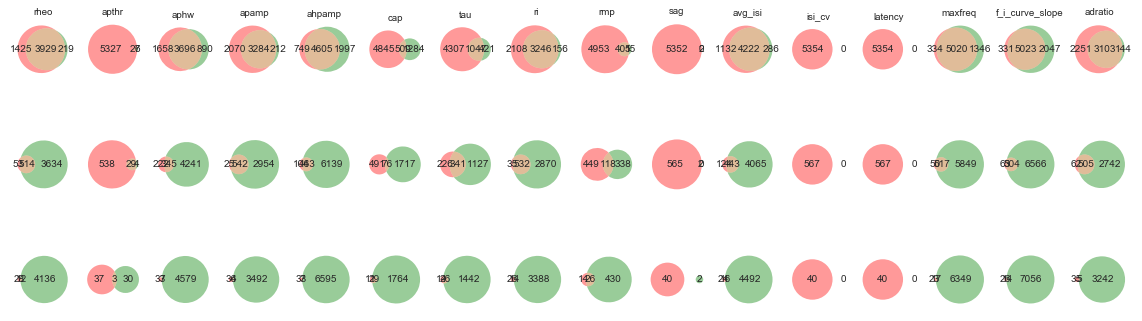

In [52]:
# How much do the PC1 genes overlap with the genes associated with ephys properties?

alpha = 0.1
condition = 'FDR_gene|class_anova'
fig, ax = plt.subplots(3, 16, figsize = (20, 6))

for y, pc in enumerate(['E_PC1', 'E_PC2', 'E_PC3']):
    qvals_pc = res[res.property == pc]
    genes_sig_pc = set(qvals_pc[qvals_pc[condition] < alpha]['gene_entrez_id'].values)
    for x, measure in enumerate(['rheo', 'apthr', 'aphw', 'apamp', 'ahpamp', 'cap', 'tau', 
                                 'ri', 'rmp', 'sag', 'avg_isi', 'isi_cv', 'latency', 
                                 'maxfreq', 'f_i_curve_slope', 'adratio']):        
        qvals = res[res.property == measure]
        genes_sig = set(qvals[qvals[condition] < alpha]['gene_entrez_id'].values)
        
        venn = venn2([genes_sig_pc, genes_sig], set_labels = None, ax = ax[y, x])
        if pc == 'E_PC1':
            ax[y, x].set_title(measure, loc = 'center')

plt.show()

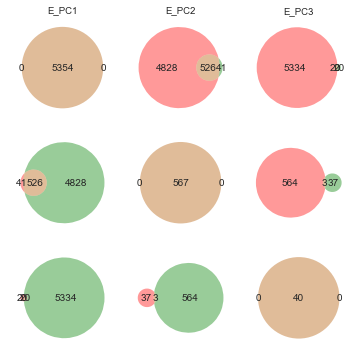

In [53]:
alpha = 0.1
condition = 'FDR_gene|class_anova'
fig, ax = plt.subplots(3, 3, figsize = (6, 6))

for y, pc in enumerate(['E_PC1', 'E_PC2', 'E_PC3']):
    qvals_pc = res[res.property == pc]
    genes_sig_pc = set(qvals_pc[qvals_pc[condition] < alpha]['gene_entrez_id'].values)
    for x, measure in enumerate(['E_PC1', 'E_PC2', 'E_PC3']):        
        qvals = res[res.property == measure]
        genes_sig = set(qvals[qvals[condition] < alpha]['gene_entrez_id'].values)
        
        venn = venn2([genes_sig_pc, genes_sig], set_labels = None, ax = ax[y, x])
        if pc == 'E_PC1':
            ax[y, x].set_title(measure, loc = 'center')

plt.show()

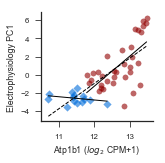

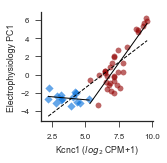

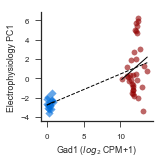

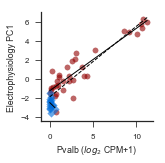

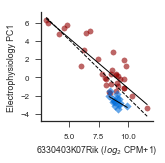

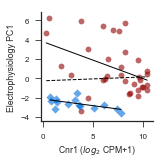

In [54]:
# Genes associated with the latent factor from Harris et al. 2018 versus E_PC1

genes_LF = ['Atp1b1', 'Kcnc1', 'Gad1', 'Pvalb', '6330403K07Rik', 'Cnr1']
genes_LF = [11931, 16502, 14415, 19293, 103712, 12801]

for gene in genes_LF:
    fig, ax = plt.subplots(figsize = (2, 2))
    make_scatter(gene, 'E_PC1', ax, df_seq, df_ephys, line_labels)
    plt.show()

In [55]:
# For which features is there a significant effect of class on feature?

res_class = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-27 Ephys/results_table_class.csv', index_col = 0)
res_class_morph = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-27 Morphology/results_table_class.csv', index_col = 0)

res_class['property'] = ['E_' + n if n.startswith('PC') else n for n in res_class['property']]
res_class_morph['property'] = ['M_' + n if n.startswith('PC') else n for n in res_class_morph['property']]

res_class = pd.concat([res_class, res_class_morph])

In [56]:
res_class['Sig'] = [n < 0.05 for n in res_class.pval_class]

In [57]:
res_class[res_class.Sig == False]

,property,beta_class,pval_class,Sig
1,apthr,-1.099447,0.097739,False
4,ri_log10,0.045119,0.222223,False
7,rheo_log10,0.025550,0.699437,False
15,sag_log10,0.001145,0.985293,False
18,E_PC3,0.726728,0.064927,False
0,average_bifurcation_angle_local,0.963138,0.509815,False
1,soma_surface,-32.783324,0.316059,False
2,branchiness_log10,0.040693,0.156173,False
7,M_PC2,-0.181710,0.638329,False
8,M_PC3,0.321948,0.377581,False


# Fig 3, Table S3 - Interactions

In [58]:
measures_rev = list(measures_all)
measures_rev.reverse()
df_exc_inh = pd.DataFrame(index = measures_rev, columns = ['r_inh_exc', 'r_inh_beta', 'r_exc_beta'])

x = 'slope_inh'
y = 'slope_exc'
z = 'beta_gene|class'

for measure in measures_rev:
    subset = res[res.property == measure]

    r_inh_exc = stats.spearmanr(subset[x], subset[y], nan_policy = 'omit')[0]
    r_inh = stats.spearmanr(subset[x], subset[z], nan_policy = 'omit')[0]
    r_exc = stats.spearmanr(subset[y], subset[z], nan_policy = 'omit')[0]
    df_exc_inh.loc[measure, 'r_inh_exc'] = r_inh_exc   
    df_exc_inh.loc[measure, 'r_inh_beta'] = r_inh
    df_exc_inh.loc[measure, 'r_exc_beta'] = r_exc

df_exc_inh = df_exc_inh.astype('float')


In [59]:
measures_nonzero = []
for measure in measures_all:
    if (res_interaction).sum(axis = 1)[measure] > 0:
        measures_nonzero.append(measure)

In [60]:
res_interaction.sum(axis = 1)

E_PC3                                 3
E_PC2                                 3
E_PC1                               560
rheo                                 88
apthr                                 3
aphw                                 93
apamp                               660
ahpamp                             3017
cap                                 155
tau                                 132
ri                                  101
rmp                                   8
sag                                1109
avg_isi                              62
isi_cv                                0
latency                               0
maxfreq                             341
f_i_curve_slope                     464
adratio                             321
M_PC3                                 0
M_PC2                                 0
M_PC1                                 0
average_bifurcation_angle_local       0
branchiness                           7
max_branch_order                   1914


In [61]:
ds = res_dict
corrtypes = ['FDR_gene|class_anova', 'FDR_int_anova']
col_labels = ['Class-conditional model', 'Interaction model', 'Significant in both models']

overlap_df_int, sig_dd_int = calculate_overlap(res_dict, corrtypes, col_labels, measure_dict, alpha = 0.1)

overlap_df_int = overlap_df_int.reindex([measure_dict[m] for m in measures_all][::-1])


In [62]:
genes_plot = [18191, 230815]

axes = []

fig = plt.figure(figsize = (7, 9.5))
gs_scatter = GridSpec(1, 2, wspace = 0.25)
gs_sig = GridSpec(1, 1)
gs_example = GridSpec(2, 1, hspace = 0.5)
gs_example.update(left = 0.65, bottom = 0.42)
gs_sig.update(bottom = 0.42, left = 0.25, right = 0.55)
gs_scatter.update(bottom = 0.1, top = 0.3, left = 0, right = 0.65)


ax = plt.subplot(gs_sig[:, :])
pal = sns.dark_palette(color_int, 4, reverse = True)[:-1]
width = 0.8
ind = np.arange(len(measures_nonzero))
res_int_nonzero = res_interaction.reindex(measures_nonzero)
b1 = ax.barh(ind, res_int_nonzero[0.1], left = res_int_nonzero[0.01] + res_int_nonzero[0.05], height = width, 
             color = pal[0], edgecolor = 'lightgrey', label = 'FDR = 0.1', log = True)
b2 = ax.barh(ind, res_int_nonzero[0.05], left = res_int_nonzero[0.01], height = width, 
             color = pal[1], edgecolor = 'lightgrey', label = 'FDR = 0.05', log = True)
b3 = ax.barh(ind, res_int_nonzero[0.01], height = width, 
             color = pal[2], edgecolor = 'lightgrey', label = 'FDR = 0.01', log = True)
ax.set_yticks(ind)
ax.set_yticklabels([measure_dict[m] for m in measures_nonzero], rotation = 0, ha = 'right')
leg = ax.legend(loc = 'upper left', bbox_to_anchor = (0, 0))
ax_leg = ax.add_artist(leg)
ax.set_xlabel('Gene count (interaction)')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False) 
ax.tick_params(axis = 'y', length=0, width=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
axes.append(ax)

# Venn diagrams
v_list = []
for ypos, measure in zip([float(n) / (len(measures_nonzero) + 1.6) + 0.005 for n in ind], measures_nonzero):
    size = 0.12
    ip = InsetPosition(ax, [-1, ypos, size, size])

    ins_ax = plt.axes([-0.9, ypos, size, size])
    ins_ax.set_axes_locator(ip)

    set1 = set(sig_dd_int[measure]['FDR_gene|class_anova'])
    set2 = set(sig_dd_int[measure]['FDR_int_anova'])
    v = venn2([set1, set2], set_labels = ('', ''), set_colors = (color_par, color_int), alpha = 1, ax = ins_ax)
    if measure == 'ahpamp':
        v_legend = v
    if v.get_patch_by_id('11') != None:
        v.get_patch_by_id('11').set_color(color_shared)
    venn2_circles([set1, set2], ax = ins_ax, linewidth = 1)
    for text in v.subset_labels:
        if text is not None:
            text.set_text('') 

h = []
for i in ['10', '01', '11']:
    h.append(v_legend.get_patch_by_id(i))
    
ax.legend(handles = h, labels = ['Class-conditional model', 'Interaction model', 'Both models'], 
          loc = 'upper left', bbox_to_anchor = (-1, 0))


for ypos, measure in enumerate(['max_branch_order', 'ahpamp']):
    ax = plt.subplot(gs_example[ypos, 0])
    subset = res[res.property == measure]
    x = subset['slope_exc']
    y = subset['slope_inh']
    z = subset['FDR_int_anova']
    z2 = subset['FDR_gene|class_anova']
    xy_id = subset['gene_entrez_id']
    xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
    xy.dropna(inplace = True)
    r = stats.spearmanr(xy.x, xy.y)
    print(r)
    if measure == 'ahpamp':
        xy_new = xy[[n not in genes_plot for n in xy.id]].sample(frac = 0.02)
        xy = pd.concat([xy_new, xy[[n in genes_plot for n in xy.id]]])
    else:
        xy = xy.sample(frac = 0.02)
    print(xy.shape)
    xlim = (np.percentile(x.dropna(), 1), np.percentile(x.dropna(), 99))
    ylim = (np.percentile(y.dropna(), 0.5), np.percentile(y.dropna(), 99.5))
    ax.plot(xlim, xlim, '--', color = 'grey', linewidth = 1)
    ax.plot(xlim, (-1 * xlim[0], -1 * xlim[1]), '--', color = 'grey', linewidth = 1)
    ax.plot([0, 0], ylim, 'k-', linewidth = 1)
    ax.plot(xlim, [0, 0], 'k-', linewidth = 1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
    xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
    xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
    xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
    s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', marker = 'o', s = 20, alpha = 0.5)
    s2 = ax.scatter(xy2.x, xy2.y, color = color_par, marker = 's', s = 20, alpha = 0.5)
    s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, marker = 'D', s = 20, alpha = 0.5)
    s1 = ax.scatter(xy1.x, xy1.y, color = color_int, marker = 'v', s = 20, alpha = 0.5)
    if measure == 'ahpamp':
        xy_examples = xy[[n in genes_plot for n in xy.id]]
        for marker, g in zip(['D', 'v'], xy_examples.index):
            ax.scatter(xy_examples.loc[g, 'x'], xy_examples.loc[g, 'y'], s = 20, marker = marker, 
                       facecolors = 'none', edgecolors = 'black', linewidths = 1)
    ax.set_xlabel('Slope Excitatory')
    ax.set_ylabel('Slope Inhibitory')
    ax.set_title(measure_dict[measure])
    axes.append(ax)

axes[2].legend([s2, s1, s0, s3], ['FDR = 0.1 class-\nconditional only', 'FDR = 0.1\ninteraction only', 
                                       'FDR = 0.1\nboth models', 'n.s.'], 
          bbox_to_anchor = (0, -0.3), loc = 'upper left', frameon = True)


# ax.annotate('r = ' + str(r[0].round(2)), (0.1, 1), xycoords = 'axes fraction', ha = 'left', va = 'top')

for n, gene in enumerate(genes_plot):
    pt = res[(res.gene_entrez_id == gene) & (res.property == measure)]
    xy_pos = (pt['slope_exc'].values[0], pt['slope_inh'].values[0])
    xytext = (pt['slope_exc'].values[0] + 0.1, pt['slope_inh'].values[0] - 0.1)
    axes[2].annotate(pt['gene_symbol'].values[0], xy_pos, xytext = xytext, 
                arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))
    ax = plt.subplot(gs_scatter[0, n])
    axes.append(ax)
    make_scatter(gene, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 50)
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes[4].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 0), 
               loc= 'lower left', frameon = True)


for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes):
    ax.annotate(letter, (-0.1, 1.05), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')
for ax in axes[1:]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig3_draft14.tiff', 
            bbox_inches = 'tight', dpi = 300)
plt.clf()

SpearmanrResult(correlation=-0.21166175850534968, pvalue=1.0544841185983415e-122)
(242, 5)
SpearmanrResult(correlation=-0.10122312692705569, pvalue=3.5507211547182428e-29)
(246, 5)


In [64]:
overlap_df_int.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS3_draft2.csv')

# Fig S3 - interactions are not only based on expression levels

In [65]:
# Do interactions have something to do with differences between E and I expression? (question from Paul)

measure = 'ahpamp'
subset = res[res.property == measure]
x = subset['slope_exc']
y = subset['slope_inh']
fdr = subset['FDR_int_anova']
xy_id = subset['gene_entrez_id']
mean_dif_list = []
for gene in xy_id:
    e_mean = df_seq.loc[gene, [n == 1 for n in line_labels]].mean()
    i_mean = df_seq.loc[gene, [n == 0 for n in line_labels]].mean()
    mean_dif = e_mean - i_mean
    mean_dif_list.append(mean_dif)
mean_dif_list = pd.Series(mean_dif_list, index = xy_id.index)
slope_dif_list = x - y

xy = pd.DataFrame([xy_id, mean_dif_list, slope_dif_list, fdr], index = ['id', 'mean_dif', 'slope_dif', 'fdr']).T
xy.dropna(inplace = True)


In [68]:

print(measure)
%config InlineBackend.figure_format = 'png'

plt.figure(figsize = (4, 3))

xy_sample = xy.sample(frac = 0.1)

xy_ns = xy_sample[xy_sample.fdr >= 0.1]
xy_s = xy_sample[xy_sample.fdr < 0.1]

s1 = plt.scatter(xy_ns.mean_dif, xy_ns.slope_dif, s = 5, alpha = 0.3, c = 'grey')
s2 = plt.scatter(xy_s.mean_dif, xy_s.slope_dif, s = 5, alpha = 1, c = xy_s.fdr, cmap = 'viridis_r')
ax = plt.gca()
ax.set_xlabel('Expression Excitatory - Expression Inhibitory')
ax.set_ylabel('Slope Excitatory - Slope Inhibitory')
xlim = np.percentile(xy_sample.mean_dif, 0.5), np.percentile(xy_sample.mean_dif, 99.5)
ylim = np.percentile(xy_sample.slope_dif, 0.5), np.percentile(xy_sample.slope_dif, 99.5)
ax.plot([0, 0], ylim, 'k-', linewidth = 1)
ax.plot(xlim, [0, 0], 'k-', linewidth = 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
r = stats.spearmanr(xy.mean_dif, xy.slope_dif)
ax.annotate('r=' + str(round(r[0], 3)), (0.95, 0.95), ha = 'right', xycoords = 'axes fraction')
c = plt.colorbar(s2)
c.set_label('q interaction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/FigS3_draft2.tiff', 
            bbox_inches = 'tight', dpi = 300)
plt.clf()

ahpamp


In [ ]:
# all measures, correlation values

for measure in measures_all:
    subset = res[res.property == measure]
    x = subset['slope_exc']
    y = subset['slope_inh']
    fdr = subset['FDR_int_anova']
    xy_id = subset['gene_entrez_id']
    mean_dif_list = []
    for gene in xy_id:
        e_mean = df_seq.loc[gene, [n == 1 for n in line_labels]].mean()
        i_mean = df_seq.loc[gene, [n == 0 for n in line_labels]].mean()
        mean_dif = e_mean - i_mean
        mean_dif_list.append(mean_dif)
    mean_dif_list = pd.Series(mean_dif_list, index = xy_id.index)
    slope_dif_list = x - y

    xy = pd.DataFrame([xy_id, mean_dif_list, slope_dif_list, fdr], index = ['id', 'mean_dif', 'slope_dif', 'fdr']).T
    xy.dropna(inplace = True)
    r = stats.spearmanr(xy.mean_dif, xy.slope_dif)
    print(measure_dict[measure], round(r[0], 3))



SpearmanrResult(correlation=-0.21166175850534968, pvalue=1.0544841185983415e-122)
(2424, 5)


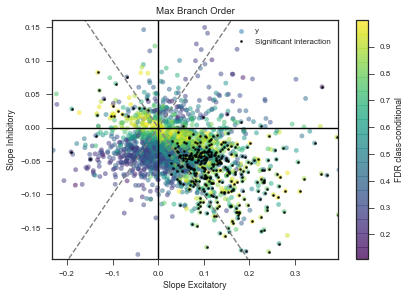

In [71]:
# Why are max branch order and sag different?

fig, ax = plt.subplots()
measure = 'max_branch_order'
subset = res[res.property == measure]
x = subset['slope_exc']
y = subset['slope_inh']
z = subset['FDR_int_anova']
z2 = subset['FDR_gene|class_anova']
xy_id = subset['gene_entrez_id']
xy = pd.DataFrame([xy_id, x, y, z, z2], index = ['id', 'x', 'y', 'z', 'z2']).T
xy.dropna(inplace = True)
r = stats.spearmanr(xy.x, xy.y)
print(r)
# xy_new = xy[[n not in [18191, 230815] for n in xy.id]].sample(frac = 0.02)
xy_new = xy.sample(frac = 0.2)
xy = pd.concat([xy_new, xy[[n in [18191, 230815] for n in xy.id]]])
print(xy.shape)
ax.set_xlim(np.percentile(x.dropna(), 0.5), np.percentile(x.dropna(), 99.5))
ax.set_ylim(np.percentile(y.dropna(), 0.1), np.percentile(y.dropna(), 99.9))
xy0 = xy[(xy.z < 0.1) & (xy.z2 < 0.1)]
xy1 = xy[(xy.z < 0.1) & (xy.z2 >= 0.1)]
xy2 = xy[(xy.z >= 0.1) & (xy.z2 < 0.1)]
xy3 = xy[(xy.z >= 0.1) & (xy.z2 >= 0.1)]
# xy_examples = xy[[n in [18191, 230815] for n in xy.id]]
# s3 = ax.scatter(xy3.x, xy3.y, color = 'grey', s = 20, alpha = 0.5)
# s2 = ax.scatter(xy2.x, xy2.y, color = color_par, s = 20, alpha = 0.5)
# s0 = ax.scatter(xy0.x, xy0.y, color = color_shared, s = 20, alpha = 0.5)
s = ax.scatter(xy.x, xy.y, c = xy.z2, cmap = 'viridis', s = 20, alpha = 0.5)
s1 = ax.scatter(xy1.x, xy1.y, color = 'black', s = 5, alpha = 1, label = 'Significant interaction')
# ax.scatter(xy_examples.x, xy_examples.y, s = 20, facecolors = 'none', edgecolors = 'black')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot(xlim, (-1 * xlim[0], -1 * xlim[1]), '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Slope Excitatory')
ax.set_ylabel('Slope Inhibitory')
ax.set_title(measure_dict[measure])
c = plt.colorbar(s)
c.set_label('FDR class-conditional')
ax.legend()

plt.show()

# Fig 4
# Consistency between NE_inh & AIBS E~G vs E~G|C

In [72]:
measure_dict_ne = {'Rin' : 'ri', 
           'Vrest' : 'rmp', 
           'APthr' : 'apthr', 
           'APamp' : 'apamp', 
           'APhw' : 'aphw', 
           'Tau' : 'tau', 
           'AHPamp' : 'ahpamp', 
           'Rheo' : 'rheo',
           'FRmax' : 'maxfreq', 
           'Cm' : 'cap',
           'SFA' : 'adratio'}


In [73]:
def analyze_consistency(res_old, res_new, bootstrap = False, subset = 'inh'):
    
    # Relabel measures    
    measures = measure_dict_ne.values()
    res_old.property = [measure_dict_ne[m] for m in res_old.property]
    set1 = 'NE'
    set2 = 'AIBS'
    
    # Re-index to include only common genes
    genes_intersect = set(res_old.gene).intersection(set(res_new.gene_symbol))
    res_old = res_old[[gene in genes_intersect for gene in res_old.gene]]
    res_old.index = [res_old.property, res_old.gene]
    res_new.index = [res_new.property, res_new.gene_symbol]
    res_new = res_new.reindex(res_old.index)
    
    res_new['E~G'] = res_new.beta_gene
    res_new['E~G|C'] = res_new['beta_gene|class']
    res_new['i_only'] = res_new.beta_gene_inh_only ###
    
    # Calculate overall correlations

    df_comparison = pd.DataFrame(index = [measure_dict[m] for m in measures], 
                                 columns = ['r (' + set1 + '_' + subset + ' vs ' + set2 + '_E~G)',
                                            'r (' + set1 + '_' + subset + ' vs ' + set2 + '_E~G|C)', 
                                            'r (' + set1 + '_' + subset + ' vs ' + set2 + '_i_only)'])

    if bootstrap:
        upper_bootstrap_list_list = []
        lower_bootstrap_list_list = []
        sig_list_class_cond = []
        sig_list_i_only = [] ###

    for measure in measures:
        if bootstrap:
            upper_bootstrap_list = []
            lower_bootstrap_list = []
            correlations_list = []
        for a in ['E~G', 'E~G|C', 'i_only']: ###
            x = res_old.loc[measure, :][subset + '_beta']
            y = res_new.loc[measure, :][a]
            r, p = stats.spearmanr(x, y, nan_policy = 'omit')
            df_comparison.loc[measure_dict[measure], 'r (' + set1 + '_' + subset + ' vs ' + set2 + '_' + a + ')'] = round(r, 3)
            
            # Bootstrap confidence intervals
            if bootstrap:
                tmp = np.array([x, y]).T
                length = tmp.shape[0]
                samples = 100
                correlations = []

                for n in range(samples):
                    resampled = tmp[randint(length, size = length)]
                    r = stats.spearmanr(resampled[:, 0], resampled[:, 1], nan_policy = 'omit')[0]
                    correlations.append(r)
                mean = np.mean(correlations)
                upper = np.percentile(correlations, 97.5) - mean
                lower = mean - np.percentile(correlations, 2.5)
                
                upper_bootstrap_list.append(upper)
                lower_bootstrap_list.append(lower)
                correlations_list.append(correlations)
        if bootstrap:
            upper_bootstrap_list_list.append(upper_bootstrap_list)            
            lower_bootstrap_list_list.append(lower_bootstrap_list)
            for n, sig_list in enumerate([sig_list_class_cond, sig_list_i_only]):
                differences = [a - b for a, b in zip(correlations_list[0], correlations_list[n + 1])]
                upper = np.percentile(differences, 97.5)
                lower = np.percentile(differences, 2.5)
                if np.sign(upper) == np.sign(lower):
                    sig_list.append(u'✻')
                else:
                    sig_list.append('')

    if bootstrap:
        df_upper = pd.DataFrame(upper_bootstrap_list_list, index = [measure_dict[m] for m in measures], 
                                columns = [subset + ' vs reg', subset + ' vs par', subset + ' vs i_only'])
        df_lower = pd.DataFrame(lower_bootstrap_list_list, index = [measure_dict[m] for m in measures], 
                                columns = [subset + ' vs reg', subset + ' vs par', subset + ' vs i_only'])
        df_sig = pd.DataFrame([sig_list_class_cond, sig_list_i_only], columns = [measure_dict[m] for m in measures], 
                              index = ['p < 0.05 vs par', 'p < 0.05 vs i_only']).T
        return df_comparison, res_old, res_new, df_upper, df_lower, df_sig
    else:
        return df_comparison, res_old, res_new

In [74]:
# analysis_folder2 = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-07-19 Neuroelectro Neuroexpresso/'
analysis_folder2 = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/'
res_old = pd.read_csv(analysis_folder2 + 'rpq_all_genes_nonprojecting_exclude_Htr3a_Oxtr.csv', index_col = 0)
res_old.rename({'ephys_measure' : 'property'}, axis = 'columns', inplace = True)

res_new = res.copy()

# With bootstrapping step - run once and then save since it takes some time to run
# df_comparison, res_old, res_new, df_upper, df_lower, df_sig = analyze_consistency(res_old, res_new, 
#                                                                                   bootstrap = True)

# No bootstrap
df_comparison, res_old, res_new = analyze_consistency(res_old, res_new, bootstrap = False)


In [75]:
# Version for paper (initial submission)
# df_upper.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-28 Bootstrap confidence intervals/error_upper.csv')
# df_lower.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-28 Bootstrap confidence intervals/error_lower.csv')
# df_sig.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-03-28 Bootstrap confidence intervals/significance.csv')

# After reviewer comments
# df_upper.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/error_upper.csv')
# df_lower.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/error_lower.csv')
# df_sig.replace(u'✻', '*').to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/significance.csv')

In [76]:
df_upper = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/error_upper.csv', index_col = 0)
df_lower = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/error_lower.csv', index_col = 0)
df_sig = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-11 Neuroelectro Neuroexpresso/significance.csv', index_col = 0).fillna('').replace('*', u'✻')

In [77]:
# Calculate whether at least one model has a positive consistency metric (including CIs)

subset = 'inh'

bootstrap_above_zero = []
for m in df_comparison.index:
    r_ind = df_comparison.loc[m, 'r (NE_' + subset + ' vs AIBS_E~G)']
    r_cond = df_comparison.loc[m, 'r (NE_' + subset + ' vs AIBS_E~G|C)']
    r_i_only = df_comparison.loc[m, 'r (NE_' + subset + ' vs AIBS_i_only)']
    interval_ind = (r_ind - df_lower.loc[m, subset + ' vs reg'], r_ind + df_upper.loc[m, subset + ' vs reg'])
    interval_cond = (r_cond - df_lower.loc[m, subset + ' vs par'], r_cond + df_upper.loc[m, subset + ' vs par'])
    interval_i_only = (r_i_only - df_lower.loc[m, subset + ' vs i_only'], r_cond + df_upper.loc[m, subset + ' vs i_only'])
    if (interval_ind[0] > 0) or (interval_cond[0] > 0) or (interval_i_only[0] > 0):
        bootstrap_above_zero.append(True)
    else:
        bootstrap_above_zero.append(False)

df_comparison['Above_zero'] = bootstrap_above_zero
df_comparison['Significant vs par'] = df_sig['p < 0.05 vs par'].values
df_comparison['Significant vs i_only'] = df_sig['p < 0.05 vs i_only'].values

In [78]:
df_comparison

,r (NE_inh vs AIBS_E~G),r (NE_inh vs AIBS_E~G|C),r (NE_inh vs AIBS_i_only),Above_zero,Significant vs par,Significant vs i_only
AP Half-width,0.16,0.255,0.231,True,✻,✻
AHP Amplitude,-0.182,-0.098,-0.151,False,✻,✻
Max Firing Frequency,0.095,0.186,0.16,True,✻,✻
Rheobase,0.248,0.25,0.232,True,,
AP Threshold,-0.033,-0.111,-0.172,False,✻,✻
AP Amplitude,-0.05,0.063,0.017,True,✻,✻
Time Constant Tau,0.283,0.217,0.196,True,✻,✻
Capacitance,0.002,-0.101,-0.105,False,✻,✻
Input Resistance,0.213,0.252,0.247,True,✻,✻
Resting Membrane Potential,0.043,0.203,0.288,True,✻,✻


In [79]:
# Version including inh-only subset

%config InlineBackend.figure_format = 'png'
# NE vs AIBS

subset = 'inh'

df = df_comparison

fig = plt.figure(figsize = (7, 8.5), dpi = 150)

gs1 = GridSpec(2, 2, height_ratios = [2, 1])
gs2 = GridSpec(1, 2)
gs1.update(left = 0.25, right = 0.85, bottom = 0.5, wspace = 0.4)
gs2.update(top = 0.35, wspace = 0.4)
axes_list = []

width = 0.3
ax = plt.subplot(gs1[:, 0])
axes_list.append(ax)
ind = np.arange(len(df.index))
ax.barh(ind + (2 * width), df['r (NE_' + subset + ' vs AIBS_E~G)'], xerr = [df_lower[subset + ' vs reg'], df_upper[subset + ' vs reg']],
        height = width, color = color_reg, label = 'Class-independent model')
ax.barh(ind + width, df['r (NE_' + subset + ' vs AIBS_E~G|C)'], xerr = [df_lower[subset + ' vs par'], df_upper[subset + ' vs par']], 
        height = width, color = color_par, label = 'Class-conditional model')
ax.barh(ind, df['r (NE_' + subset + ' vs AIBS_i_only)'], xerr = [df_lower[subset + ' vs i_only'], df_upper[subset + ' vs i_only']], 
        height = width, color = 'grey', label = 'Inhibitory only')
xlim = ax.get_xlim()
ax.set_xlim(xlim[0] * 1.1, xlim[1] * 1.1)
ylim = ax.get_ylim()
ax.plot([0, 0], ylim, 'k-')
ax.set_ylim(ylim)
ax.set_yticks(ind + (0.5 * width))
ax.set_yticklabels(df.index, rotation = 0, ha = 'right')
ax.set_xlabel('Consistency AIBS vs NE')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis = 'y', length=0, width=0)
ax.legend(loc = 'lower left', bbox_to_anchor = (1.1, 0), borderaxespad = 0)

for i, measure in zip(ind, df_comparison.index):
    above_zero = df_comparison.loc[measure, 'Above_zero']
    for n, comparison in enumerate(['i_only', 'par']):
        star = df_comparison.loc[measure, 'Significant vs ' + comparison]
        ypos = df_comparison.loc[measure, 'r (NE_' + subset + ' vs AIBS' + ('_E~G|C' if comparison == 'par' else '_i_only') + ')']
        ypos += (np.copysign(0.04, ypos))
        if above_zero & (star == u'✻'):
            ax.annotate(star, (ypos, i + (n * width)), 
                ha = 'center', va = 'center', fontsize = 10, rotation = 270, fontname = 'DejaVu Sans', xycoords = 'data')


        
measure = 'aphw'        

ax = plt.subplot(gs1[0, 1])
axes_list.append(ax)
for xpos, var_x, label1, label2, label3, color in zip([1, 2, 3], ['beta_gene', 'beta_gene|class', 'beta_gene_inh_only'], 
                                                      ['Class-independent\nmodel slope', 'Class-conditional\nmodel slope', 'Inhibitory only slope'], 
                                                      ['_reg', '_par', '_inhib'], ['ind', 'cond', 'inhib'], [color_reg, color_par, 'grey']):
    x = res_new[res_new.property == measure][var_x]
    y = res_old[res_old.property == measure][subset + '_beta']
    xy = pd.DataFrame([x, y], index = ['x', 'y']).dropna(axis = 1)
    fit = np.polyfit(xy.loc['x'], xy.loc['y'], deg = 1)
    r = round(stats.spearmanr(list(xy.loc['x'].values), list(xy.loc['y'].values))[0], 3)
    xy = xy.sample(frac = 0.1, axis = 1)
    lim = pd.Series([min(list(xy.loc['x'].values)), max(list(xy.loc['x'].values))])
    
    ax.scatter(xy.loc['x'], xy.loc['y'], alpha = 0.3, s = 2, color = color)

    ax.plot(lim, lim * fit[0] + fit[1], '-', color = color, linewidth = 1)
    ax.annotate(r'$r_{' + label3 + '}$ = ' + str(r), (lim[1], lim[1] * fit[0] + fit[1] + (0.1 if label3 == 'cond' else -0.05 if label3 == 'inhib' else -0.1)))
    ax.set_xlabel('Model Slope (AIBS)')
    ax.set_ylabel('Model Slope (NE non-projecting)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    ax.set_title(measure_dict[measure])
    ax.set_ylim([-1, 1])
    ax.set_yticks([-1, 0, 1])
    
        
gene = 'Atp2a2'
gene_id = 11938

# AIBS data
ax = plt.subplot(gs2[0, 0])
axes_list.append(ax)
make_scatter(gene_id, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
             line_labels = line_labels, unit = 'CPM', s = 50)
a1 = r'$\beta_{ind}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.property == measure)]['beta_gene'].values[0], 3))
a2 = r'$\beta_{cond}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.property == measure)]['beta_gene|class'].values[0], 3))

ax.annotate(a1 + ', ' + a2, (0.05, 1), xycoords = 'axes fraction', ha = 'left', va = 'bottom')

# NE data
ax = plt.subplot(gs2[0, 1])
axes_list.append(ax)
x = ne_inh[gene]
y = ne_inh['APhw']
ax.scatter(x, y, s = 50, alpha = 0.6, c = 'black')
idx = np.isfinite(x) & np.isfinite(y)
if len(x[idx]) > 1:
    fit = np.polyfit(x[idx], y[idx], deg = 1)
    lim = pd.Series([x[idx].min(), x[idx].max()])
    ax.plot(lim, lim * fit[0] + fit[1], '-', linewidth = 1, color = 'black')
    r = round(stats.spearmanr(x, y, nan_policy = 'omit')[0], 3)
ax.set_xlabel(gene + ' ($log_2$ expr)')
ax.set_ylabel(measure_dict[measure] + ' (ms)')
ax.annotate('r = ' + str(r), (0.05, 1), xycoords = 'axes fraction', 
        ha = 'left', va = 'bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

i = axes_list[2].scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = axes_list[2].scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes_list[2].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, -0.3), 
                    loc= 'upper left', frameon = True, ncol = 2, borderaxespad = 0, handletextpad = 0) 

axes_list[2].set_title('AIBS\n')
axes_list[3].set_title('NE (non-projecting)\n')

for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes_list):
    ax.annotate(letter, (-0.1, 1.02) if letter == 'A' else (-0.1, 1.04),
                ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig4_draft17.png', bbox_inches = 'tight')
plt.clf()

In [80]:
# Version for paper

%config InlineBackend.figure_format = 'png'
# NE vs AIBS

subset = 'inh'

df = df_comparison

fig = plt.figure(figsize = (7, 8.5), dpi = 150)

gs1 = GridSpec(2, 2, height_ratios = [2, 1])
gs2 = GridSpec(1, 2)
gs1.update(left = 0.25, right = 0.85, bottom = 0.5, wspace = 0.4)
gs2.update(top = 0.35, wspace = 0.4)
axes_list = []

width = 0.4
ax = plt.subplot(gs1[:, 0])
axes_list.append(ax)
ind = np.arange(len(df.index))
ax.barh(ind + width, df['r (NE_' + subset + ' vs AIBS_E~G)'], xerr = [df_lower[subset + ' vs reg'], df_upper[subset + ' vs reg']],
        height = width, color = color_reg, label = 'Class-independent model')
ax.barh(ind, df['r (NE_' + subset + ' vs AIBS_E~G|C)'], xerr = [df_lower[subset + ' vs par'], df_upper[subset + ' vs par']], 
        height = width, color = color_par, label = 'Class-conditional model')

xlim = ax.get_xlim()
ax.set_xlim(xlim[0] * 1.1, xlim[1] * 1.1)
ylim = ax.get_ylim()
ax.plot([0, 0], ylim, 'k-')
ax.set_ylim(ylim)
ax.set_yticks(ind + (0.5 * width))
ax.set_yticklabels(df.index, rotation = 0, ha = 'right')
ax.set_xlabel('Consistency AIBS vs NE')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis = 'y', length=0, width=0)
ax.legend(loc = 'lower left', bbox_to_anchor = (1.1, 0), borderaxespad = 0)

for i, measure in zip(ind, df_comparison.index):
    above_zero = df_comparison.loc[measure, 'Above_zero']
    comparison = 'par'
    star = df_comparison.loc[measure, 'Significant vs ' + comparison]
    ypos = max([df_comparison.loc[measure, 'r (NE_' + subset + ' vs AIBS_E~G)'],
                df_comparison.loc[measure, 'r (NE_' + subset + ' vs AIBS_E~G|C)']])
    ypos += (np.copysign(0.03, ypos))
    if above_zero & (star == u'✻'):
        ax.annotate(star, (ypos + 0.02, i + (0.5 * width)), 
            ha = 'center', va = 'center', fontsize = 10, rotation = 270, fontname = 'DejaVu Sans', xycoords = 'data')
        ax.annotate('', (ypos, i - (0.5 * width)), (ypos, i + (1.5 * width)), arrowprops=dict(arrowstyle = '-', linewidth = 1))


        
measure = 'aphw'        

ax = plt.subplot(gs1[0, 1])
axes_list.append(ax)
for xpos, var_x, label1, label2, label3, color in zip([1, 2], ['beta_gene', 'beta_gene|class'], 
                                                      ['Class-independent\nmodel slope', 'Class-conditional\nmodel slope'], 
                                                      ['_reg', '_par'], ['ind', 'cond'], [color_reg, color_par]):
    x = res_new[res_new.property == measure][var_x]
    y = res_old[res_old.property == measure][subset + '_beta']
    xy = pd.DataFrame([x, y], index = ['x', 'y']).dropna(axis = 1)
    fit = np.polyfit(xy.loc['x'], xy.loc['y'], deg = 1)
    r = round(stats.spearmanr(list(xy.loc['x'].values), list(xy.loc['y'].values))[0], 3)
    xy = xy.sample(frac = 0.1, axis = 1)
    lim = pd.Series([min(list(xy.loc['x'].values)), max(list(xy.loc['x'].values))])
    
    ax.scatter(xy.loc['x'], xy.loc['y'], alpha = 0.3, s = 2, color = color)

    ax.plot(lim, lim * fit[0] + fit[1], '-', color = color, linewidth = 1)
    ax.annotate(r'$r_{' + label3 + '}$ = ' + str(r), (lim[1], lim[1] * fit[0] + fit[1] + (0.1 if label3 == 'cond' else -0.05 if label3 == 'inhib' else -0.1)))
    ax.set_xlabel('Model Slope (AIBS)')
    ax.set_ylabel('Model Slope (NE non-projecting)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    ax.set_title(measure_dict[measure])
    ax.set_ylim([-1, 1])
    ax.set_yticks([-1, 0, 1])
    
        
gene = 'Atp2a2'
gene_id = 11938

# AIBS data
ax = plt.subplot(gs2[0, 0])
axes_list.append(ax)
make_scatter(gene_id, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
             line_labels = line_labels, unit = 'CPM', s = 50)
a1 = r'$\beta_{ind}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.property == measure)]['beta_gene'].values[0], 3))
a2 = r'$\beta_{cond}$ = ' + str(round(res[(res.gene_entrez_id == gene_id) & 
                                                        (res.property == measure)]['beta_gene|class'].values[0], 3))

ax.annotate(a1 + ', ' + a2, (0.05, 1), xycoords = 'axes fraction', ha = 'left', va = 'bottom')

# NE data
ax = plt.subplot(gs2[0, 1])
axes_list.append(ax)
x = ne_inh[gene]
y = ne_inh['APhw']
ax.scatter(x, y, s = 50, alpha = 0.6, c = 'black')
idx = np.isfinite(x) & np.isfinite(y)
if len(x[idx]) > 1:
    fit = np.polyfit(x[idx], y[idx], deg = 1)
    lim = pd.Series([x[idx].min(), x[idx].max()])
    ax.plot(lim, lim * fit[0] + fit[1], '-', linewidth = 1, color = 'black')
    r = round(stats.spearmanr(x, y, nan_policy = 'omit')[0], 3)
ax.set_xlabel(gene + ' ($log_2$ expr)')
ax.set_ylabel(measure_dict[measure] + ' (ms)')
ax.annotate('r = ' + str(r), (0.05, 1), xycoords = 'axes fraction', 
        ha = 'left', va = 'bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

i = axes_list[2].scatter([], [], color = color_inh, marker = 'o', s = 50, alpha = 0.6)
e = axes_list[2].scatter([], [], color = color_exc, marker = 'D', s = 50, alpha = 0.6)
axes_list[2].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, -0.3), 
                    loc= 'upper left', frameon = True, ncol = 2, borderaxespad = 0, handletextpad = 0) 

axes_list[2].set_title('AIBS\n')
axes_list[3].set_title('NE (non-projecting)\n')

for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes_list):
    ax.annotate(letter, (-0.1, 1.02) if letter == 'A' else (-0.1, 1.04),
                ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig4_draft18.tiff', 
            bbox_inches = 'tight', dpi = 300)
plt.clf()

# Fig 6
# VG Potassium channels - E~G vs E~G|C

In [81]:
# how many total genes for AHPamp at FDR < 0.01 versus 0.1?

# Since this is a property with lots of significant genes, makes sense to use a more stringent threshold than for some others
# If I didn't know anything about how this property were regulated I would probably be more interested in the 
    # FDR < 0.01 group than the FDR < 0.1.

print(res[(res.property == 'ahpamp') & (res['FDR_gene|class_anova'] < 0.1)].shape[0])
print(res[(res.property == 'ahpamp') & (res['FDR_gene|class_anova'] < 0.01)].shape[0])

6602
3238


In [82]:
# From Alexander et al. 2017

channel_list = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/targets_and_families.csv', index_col = 0)

In [83]:
genes_kch_list = list(channel_list[channel_list['Family name'] == 'Voltage-gated potassium channels']['Mouse Entrez Gene'].values)

In [84]:
r_kch_par = res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id]][['gene_entrez_id', 'property', 'beta_gene|class', 'FDR_gene|class_anova']]
r_kch_reg = res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id]][['gene_entrez_id', 'property', 'beta_gene', 'FDR_gene']]
r_kch_par.columns = ['gene', 'Measure', 'beta', 'FDR']
r_kch_reg.columns = ['gene', 'Measure', 'beta', 'FDR']
r_kch_par['corrtype'] = 'partial'
r_kch_reg['corrtype'] = 'regular'
kch_r_combined = pd.concat([r_kch_par, r_kch_reg])


In [85]:
kch_r_combined['Sig_Lvl'] = [0.01 if FDR < 0.01 else 0.05 if FDR < 0.05 else 0.1 if FDR < 0.1 else 'n.s.' for FDR in kch_r_combined.FDR]

In [86]:
kch_r_ahpamp = kch_r_combined[kch_r_combined.Measure == 'ahpamp']

In [87]:
kch_r_ahpamp = kch_r_ahpamp.sort_values('Sig_Lvl', ascending = False)

In [88]:
set(kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & 
                 (kch_r_ahpamp.Sig_Lvl == 0.05)]['gene']).intersection(set(kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'regular') & 
                                                                                        (kch_r_ahpamp.Sig_Lvl == 0.01)]['gene']))



{16492}

In [89]:
kch_beta = kch_r_ahpamp.pivot(index = 'gene', columns = 'corrtype', values = 'beta')
kch_sig = kch_r_ahpamp.pivot(index = 'gene', columns = 'corrtype', values = 'FDR')
kch_sig.columns = ['FDR_partial', 'FDR_regular']
kch_beta = pd.concat([kch_beta, kch_sig], axis = 1)

In [90]:
kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.Sig_Lvl == 0.01) & (kch_r_ahpamp.beta > 0)].shape

(11, 6)

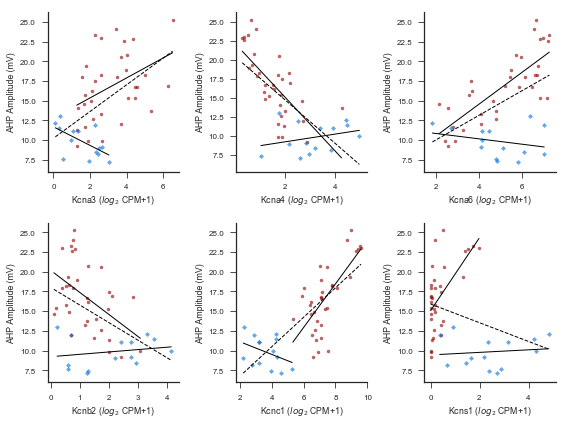

In [91]:
# VG Potassium channels with signficant interactions

fig, axes = plt.subplots(2, 3, figsize = (8, 6))

for gene, ax in zip(res[[str(gene) in genes_kch_list for gene in res.gene_entrez_id] &
                        (res.FDR_int_anova < 0.1) & 
                        (res.property == 'ahpamp')]['gene_entrez_id'], axes.flat):
    make_scatter(gene, 'ahpamp', ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 10)
plt.tight_layout()
plt.show()
    
    

In [92]:
%config InlineBackend.figure_format = 'svg'

import seaborn as sns

genes_plot = [16512, 170738, 268345]

measure = 'ahpamp'
rows = 2
cols = 3

fig = plt.figure(figsize = (7, 3.5))
gs = GridSpec(rows, cols, width_ratios = [1, 1, 2.5])
axes_list = []

# Schematic
img = mpimg.imread('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/AHPamp.png')
ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.imshow(img, cmap = 'gray', interpolation = 'None')
axes_list.append(ax)

# Example genes
for gene, title, xpos, ypos in zip(genes_plot, ('Class-driven', 'Non-class-driven', 'Non-class-driven;\nsig. in both models'), (1, 0, 1), (0, 1, 1)):
    if xpos == 0:
        ax = plt.subplot(gs[ypos, xpos])
        ax_share = ax
    elif (xpos == 1) & (ypos == 0):
        ax = plt.subplot(gs[ypos, xpos])
    else:
        ax = plt.subplot(gs[ypos, xpos], sharey = ax_share)
    axes_list.append(ax)
    make_scatter(gene, measure, ax, df_seq, df_ephys, line_labels, unit = 'CPM', s = 15)

    ax.set_title(title)

# Summary scatter plot
palette = {'regular' : color_reg, 'partial' : color_par}
ax = plt.subplot(gs[:, 2])

xy0 = kch_beta[(kch_beta.FDR_partial < 0.01) & (kch_beta.FDR_regular < 0.01)]
xy1 = kch_beta[(kch_beta.FDR_partial < 0.01) & (kch_beta.FDR_regular >= 0.01)]
xy2 = kch_beta[(kch_beta.FDR_partial >= 0.01) & (kch_beta.FDR_regular < 0.01)]
xy3 = kch_beta[(kch_beta.FDR_partial >= 0.01) & (kch_beta.FDR_regular >= 0.01)]
s3 = ax.scatter(xy3.regular, xy3.partial, color = 'grey', s = 50, marker = 'o', alpha = 0.5)
s2 = ax.scatter(xy2.regular, xy2.partial, color = color_reg, s = 50, marker = '^', alpha = 0.5)
s1 = ax.scatter(xy1.regular, xy1.partial, color = color_par, s = 50, marker = 's', alpha = 0.5)
s0 = ax.scatter(xy0.regular, xy0.partial, color = color_shared, s = 50, marker = 'D', alpha = 0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, xlim, '--', color = 'grey')
ax.plot([0, 0], ylim, 'k-')
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
for gene, marker in zip(genes_plot, ['^', 's', 'D']):
    xy_pos = (kch_beta.loc[gene].regular, kch_beta.loc[gene].partial)
    xytext = (kch_beta.loc[gene].regular - 0.01, kch_beta.loc[gene].partial + 0.07)
    ax.scatter(kch_beta.loc[gene].regular, kch_beta.loc[gene].partial, s = 50, marker = marker, 
               facecolors = 'none', edgecolors = 'black', linewidth = 1)
    ax.annotate(res[(res.gene_entrez_id == gene) & (res.property == measure)]['gene_symbol'].values[0], 
                xy = xy_pos, xytext = xytext, 
                arrowprops=dict(facecolor='black', width = 1, headwidth = 1, shrink=0.05))

ax.set_xlabel('slope (class-independent)')
ax.set_ylabel('slope (class-conditional)')

ax.legend([s2, s1, s0, s3], ['FDR = 0.01 class-\nindependent only', 'FDR = 0.01 class-\nconditional only', 
                                      'FDR = 0.01\nboth models', 'n.s.'], 
          bbox_to_anchor = (1, 0), loc = 'lower right', frameon = True)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
axes_list.append(ax)    
        
    
gs.tight_layout(fig)

ax = axes_list[2]
i = ax.scatter([], [], color = color_inh, marker = 'o', s = 15, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 15, alpha = 0.6)
ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, 1.3), loc= 'lower left', frameon = True, fontsize = 10)



for letter, ax in zip(['A', 'B', 'C', 'D', 'E'], axes_list):
    ax.annotate(letter, (-0.1, 1.05), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')

plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig6_draft13.tiff', 
            bbox_inches = 'tight', dpi = 300)    
plt.clf()

In [93]:
kch_r_ahpamp[(kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta < 0)].shape

(10, 6)

In [94]:
reg_pos = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'regular') & (kch_r_ahpamp.beta > 0)]['gene'].values)
reg_neg = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'regular') & (kch_r_ahpamp.beta < 0)]['gene'].values)
par_pos = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta > 0)]['gene'].values)
par_neg = list(kch_r_ahpamp[(kch_r_ahpamp.FDR < 0.01) & (kch_r_ahpamp.corrtype == 'partial') & (kch_r_ahpamp.beta < 0)]['gene'].values)



In [95]:
both_pos = set(par_pos).intersection(set(reg_pos))
par_only_pos = set(par_pos).difference(set(reg_pos))
reg_only_pos = set(reg_pos).difference(set(par_pos))

both_neg = set(par_neg).intersection(set(reg_neg))
par_only_neg = set(par_neg).difference(set(reg_neg))
reg_only_neg = set(reg_neg).difference(set(par_neg))

In [96]:
print('positive correlations:')
print('class-independent only:', len(reg_pos))
print('class-conditional only:', len(par_pos))
print('both', len(both_pos))
print('negative correlations:')
print('class-independent only:', len(reg_neg))
print('class-conditional only:', len(par_neg))
print('both', len(both_neg))
print('both directions')
print('class-independent:', len(reg_pos) + len(reg_neg))
print('class-conditional:', len(par_pos) + len(par_neg))

positive correlations:
('class-independent only:', 8)
('class-conditional only:', 11)
('both', 6)
negative correlations:
('class-independent only:', 9)
('class-conditional only:', 2)
('both', 1)
both directions
('class-independent:', 17)
('class-conditional:', 13)


# Correlated ion channel genes

In [ ]:
import re
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.associations import read_ncbi_gene2go
from goatools.go_search import GoSearch

# Given a GO term, return a list of associated genes

def goterm_to_genes(go_term):
    obo_fname = download_go_basic_obo()
    gene2go = download_ncbi_associations()
    go2geneids_mouse = read_ncbi_gene2go("gene2go", taxids=[10090], go2geneids=True)
    print("{N} GO terms associated with mouse NCBI Entrez GeneIDs".format(N=len(go2geneids_mouse)))

    srchhelp = GoSearch("go-basic.obo", go2items=go2geneids_mouse)
    term_all = re.compile(go_term, flags=re.IGNORECASE)
    term_not = re.compile(go_term + '.independent', flags=re.IGNORECASE)

    fout_allgos = go_term + "_gos_mouse.log" 
    with open(fout_allgos, "w") as log:
        gos_m_all = srchhelp.get_matching_gos(term_all, prt=log)
        gos_no_m = srchhelp.get_matching_gos(term_not, gos=gos_m_all, prt=log)
        gos = gos_m_all.difference(gos_no_m)
        gos_all = srchhelp.add_children_gos(gos)
        geneids = srchhelp.get_items(gos_all)
    print('{N} mouse NCBI Entrez GeneIDs related to '.format(N=len(geneids)) + go_term + ' found.')
    
    return geneids

In [ ]:
channels_entrez = goterm_to_genes('ion channel activity')

In [ ]:
for measure in ['maxfreq', 'aphw']:

    prop_channels = res[(res.property == measure) & 
                           ([gene in channels_entrez for gene in res.gene_entrez_id])]

    prop_channels = prop_channels.sort_values('FDR_gene|class_anova')[:50]
    
    print(measure, prop_channels.iloc[-1]['FDR_gene|class_anova']) # FDR-corrected pval of #50 most significant gene
    
    prop_channels.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2019-04-01 Lit Curation/top50_' + measure + '.csv')

# Fig 7, Table 2
# Example genes

In [97]:
# Get only significant gene/ephys combos

res_sig_gc = res[res['FDR_gene|class_anova'] < 0.1]
counts_gc = res_sig_gc.groupby('gene_entrez_id')['property'].count()
res_sig_int = res[res['FDR_int_anova'] < 0.1]
counts_int = res_sig_int.groupby('gene_entrez_id')['property'].count()

res_sig = pd.concat([res_sig_gc, res_sig_int])
res_sig.drop_duplicates(inplace = True)

In [98]:
# Add count of number of significant features for a given gene (0.1) as a column

counts_col_gc = []
counts_col_int = []
for gene in res_sig.gene_entrez_id:
    counts_col_gc.append(counts_gc[gene] if gene in counts_gc.index else 0)
    counts_col_int.append(counts_int[gene] if gene in counts_int.index else 0)
res_sig.loc[:, 'n_significant_0.1_g|c'] = counts_col_gc
res_sig.loc[:, 'n_significant_0.1_int'] = counts_col_int

# Online tables 1 and 2 - beta, significance values

In [99]:
# Save as supplementary table

tables_folder = '/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Online Tables/'
res_sig.to_csv(tables_folder + 'online_table1.csv')
res.to_csv(tables_folder + 'online_table2.csv')

In [100]:
names_list = [id_to_name[gene] for gene in res_sig.gene_entrez_id]

res_sig.loc[:, 'gene_name'] = names_list

In [101]:
# Select only genes that are:
    # Significant (E~G|C)
    # not near significance using E~G
    # No interaction

res_top = res_sig[(res_sig['FDR_gene|class_anova'] < 0.1) & 
                  (res_sig['FDR_gene'] > 0.2) & 
                  (res_sig['FDR_int_anova'] > 0.2)]
 
res_top = res_top.sort_values('FDR_gene|class_anova')

In [102]:
res_select = pd.DataFrame(columns = res_top.columns)

# Select top 3 genes per property
for measure in measures_all:
    res_select = pd.concat([res_select, res_top[res_top.property == measure].iloc[:3]])

# Add hand-selected genes to table & heatmap
genes = [16485, 20266, 66725, 16498, 19337, 70208, 260305, 208846]
measures = ['maxfreq', 'aphw', 'branchiness', 'maxfreq', 'ahpamp', 'ahpamp', 'aphw', 'aphw']

for gene, measure in zip(genes, measures):
    res_select = pd.concat([res_select, res_sig[(res_sig.gene_entrez_id == gene) & (res_sig.property == measure)]])
    
# Make prettier version for Table 2
table2 = res_select[['property',
                         'gene_symbol',
                         'gene_name',
                         'FDR_gene|class_anova',
                         'beta_gene|class']]

directions = ['+' if n > 0 else '-' for n in table2['beta_gene|class']]
table2.loc[:, 'Direction'] = directions

table2.loc[:, 'gene_symbol'] = [n + ('*' if n in [id_to_symbol[g] for g in genes] else '') for n in table2['gene_symbol']] 

table2.columns = ['Property', 'Gene', 'Gene Name', 'FDR', 'Slope', 'Direction']

properties = [measure_dict[m] for m in table2.Property]
table2.loc[:, 'Property'] = properties    

//anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [104]:
table2.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/Table2_draft3.csv')

In [105]:
measures_hm = list(res_select.property.unique())
genes_hm = res_select.gene_symbol

res_hm = res[[gene in genes_hm.values for gene in res.gene_symbol]]
res_hm = res_hm[[m in measures_hm for m in res_hm.property]]

res_hm = res_hm.pivot('gene_symbol', 'property', 'FDR_gene|class_anova')
res_hm.columns = [measure_dict[m] for m in res_hm.columns]
res_hm.index = [n + ('*' if n in [id_to_symbol[g] for g in genes] else '') for n in res_hm.index]    


In [106]:
# Without filtering for specificity, directionless, log10
from matplotlib.colors import LogNorm
from __future__ import unicode_literals

genes = [16485, 20266, 66725, 16498, 19337, 70208, 260305, 208846]
measures = ['maxfreq', 'aphw', 'branchiness', 'maxfreq', 'ahpamp', 'ahpamp', 'aphw', 'aphw']

axes = []

cmap = matplotlib.cm.viridis_r
cmap.set_bad('lightgray',1.)
cbar_ticks = [1e-1, 1e-3, 1e-5]
c = sns.clustermap(res_hm, figsize = (7, 9.5), cmap = cmap, mask = res_hm >= 0.1, norm = LogNorm(vmin = res_hm.min(), vmax = 0.1), 
                   vmax = 0.1, cbar_kws = {'label' : '             q', 'ticks' : cbar_ticks}, 
                   robust = True, yticklabels = True)
c.ax_row_dendrogram.set_visible(False)
ax_hm = plt.gca()

gs1 = GridSpec(4, 1, hspace = 0.5)
gs2 = c.gs
gs3 = GridSpec(4, 1, hspace = 0.5)
gs2.set_width_ratios([0.05, 0, 1])
ratios = gs2.get_height_ratios()
gs2.set_height_ratios([ratios[0] / 1.2, ratios[1] / 1.2, ratios[2]])
gs1.update(left = 0.1, right = 0.27)
gs2.update(left = 0.32, right = 0.61, bottom = 0.25)
gs3.update(left = 0.83, right = 1)

ax_hm.yaxis.set_ticks_position('left')
ax_hm.tick_params(axis = 'y', length=2)
ax_hm.yaxis.set_tick_params(pad=1)

axes = []

for gene, measure, ypos in zip(genes[:4], measures[:4], range(4)):
    ax = plt.subplot(gs1[ypos, 0])
    axes.append(ax)
    if measure == 'branchiness':
        make_scatter(gene, measure, ax, df_seq = df_seq_morph, df_ephys = df_morph, 
                     line_labels = line_labels_morph, unit = 'CPM', s = 30) 
        ax.set_ylim(0.01, 0.04)
    else:
        make_scatter(gene, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
                     line_labels = line_labels, unit = 'CPM', s = 30, log = True if measure == 'maxfreq' else False)

i = ax.scatter([], [], color = color_inh, marker = 'o', s = 30, alpha = 0.6)
e = ax.scatter([], [], color = color_exc, marker = 'D', s = 30, alpha = 0.6)
axes[0].legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(0, 1), loc= 'lower left', frameon = True)

axes.append(ax_hm)

genes = [19337, 70208, 260305, 208846]
measures = ['ahpamp', 'ahpamp', 'aphw', 'aphw']

for gene, measure, ypos in zip(genes, measures, range(4)):
    ax = plt.subplot(gs3[ypos, 0])
    axes.append(ax)
    make_scatter(gene, measure, ax, df_seq = df_seq, df_ephys = df_ephys, 
                     line_labels = line_labels, unit = 'CPM', s = 30)
    

for letter, ax in zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], axes):
    y = 1.1 if letter == 'E' else 1.02
    ax.annotate(letter, (-0.05, y), ha = 'right', va = 'bottom', xycoords = 'axes fraction', weight = 'bold')        
    
plt.savefig('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Figures/Fig7_draft6.tiff', 
            bbox_inches = 'tight', dpi = 300)    
plt.clf()

# Table S1 - cell type definitions & counts

In [ ]:
counts_ephys = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-09/Counts.csv', index_col = 0)
counts_morph = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Analysis/2018-10-16/Counts.csv', index_col = 0)

counts_ephys.index = pd.MultiIndex.from_tuples([tuple(n.split('__')) for n in counts_ephys.index])
counts_morph.index = pd.MultiIndex.from_tuples([tuple(n.split('__')) for n in counts_morph.index])

counts_morph.columns = ['RNA_seq_duplicate', 'Morphology']
counts_combined = pd.concat([counts_ephys, counts_morph], axis = 1)
counts_combined.RNA_seq = counts_combined.RNA_seq.combine_first(counts_combined.RNA_seq_duplicate)
counts_combined.drop(['RNA_seq_duplicate'], axis = 1, inplace = True)

count_cells = counts_combined.sum(axis = 0)
count_types = counts_combined.count(axis = 0)

counts_combined.loc[('Number of Cells', '', '')] = count_cells
counts_combined.loc[('Number of Types', '', '')] = count_types

counts_combined.to_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Tables/TableS1.csv')

# AIC plots

In [ ]:
fig, axes = plt.subplots(3, 3, figsize = (7, 7))

df = res[res.ephys_measure == 'ahpamp']

for ypos, x in enumerate(['model1', 'model2', 'model3']):
    for xpos, y, c in zip(range(3), ['model2', 'model3', 'model4'], ['pval_gene', 'pval_gene|class_anova', 'pval_int_anova']):
        ax = axes[ypos, xpos]
        if (x != y) & (xpos >= ypos):
            s = ax.scatter(df[x + '_aic'], df[y + '_aic'], c = df['pval_gene|class_anova'], cmap = 'viridis', s = 3, alpha = 0.5)
            ax.set_xlabel(x + ' AIC')
            ax.set_ylabel(y + ' AIC')
            ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], '-', color = 'black', linewidth = 0.5)
        else:
            ax.axis('off')

# plt.colorbar(s)
plt.tight_layout()
plt.show()

# Interactions and EI balance
cool idea but didn't work

We wanted to see whether genes with a known association with epilepsy would be more likely to show a significant interaction for properties like maximum frequency or F/I curve slope. This would make sense, since differentially regulating these properties in different classes might make perturbing them more likely to shift E/I balance. This didn't really pan out, which I think it just attributable to things like circuit effects, indirect regulation of firing frequency, biology is complicated, etc.

Epilepsy gene lists from:  
http://www.wzgenomics.cn/EpilepsyGene/download.php  
https://erminej.msl.ubc.ca/help/input-files/gene-sets/

In [ ]:
fi = res[(res.ephys_measure == 'f_i_curve_slope') & 
    (res.FDR_int_anova < 0.1) & 
    (res.slope_inh > res.slope_exc)]['gene_entrez_id'].values

mf = res[(res.ephys_measure == 'maxfreq') & 
    (res.FDR_int_anova < 0.1) & 
    (res.slope_inh > res.slope_exc)]['gene_entrez_id'].values



In [ ]:
len(fi)

In [ ]:
len(mf)

In [ ]:
fi_mf = list(set(fi).union(set(mf)))

In [ ]:
len(fi_mf)

In [ ]:
fi_mf_names = [id_to_symbol[n] for n in fi_mf]

In [ ]:
'Scn1a' in fi_mf_names

In [ ]:
epilepsy = []

with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Phenocarta_ErmineJ_mouseGenesets.tsv', 'r') as f:
    for line in f:
        l = line.strip().split('\t')
        if len(l) > 2:
            if 'epilepsy' in str(l[1]):
                epilepsy = epilepsy + l[2:]

epilepsy = [str(n) for n in epilepsy]

In [ ]:
epilepsy_specific = []
epilepsy_labels = []

with open('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Phenocarta_ErmineJ_mouseGenesets.tsv', 'r') as f:
    for line in f:
        l = line.strip().split('\t')
        if len(l) > 2:
            if 'epilepsy' in str(l[1]):
                epilepsy_specific.append([str(n) for n in l[2:]])
                epilepsy_labels.append(str(l[1]))



In [ ]:
set(fi_mf_names).intersection(set(epilepsy))

In [ ]:
len(fi_mf_names)

In [ ]:
epilepsy2 = pd.read_table('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/high-confidence-gene.xls')

epilepsy2.columns = ['Category',
 'Gene_symbol',
 'Number of mutations',
 'Score',
 'Related phenotpes']

In [ ]:
# gene_map = pd.read_csv('/Users/Claire/Dropbox/Allen_Institute_Stuff/Ephys_GE/Transcription_Factors/all_genes_human_mouse.csv', index_col = 0)

# m_to_h = {}
# h_to_m = {}
# for hgene in gene_map.index:
#     mgene = gene_map.loc[hgene].values[0]
#     if isinstance(mgene, np.ndarray):
#         mgene = mgene[0]
#     if isinstance(mgene, str) and isinstance(hgene, str):
#         m_to_h[mgene] = hgene
#         h_to_m[hgene] = mgene

In [ ]:
epilepsy2['gene_symbol_mouse'] = [h_to_m[n] if n in h_to_m.keys() else np.nan for n in epilepsy2.Gene_symbol]

In [ ]:
epilepsy2.dropna(inplace = True)

In [ ]:
epilepsy_all = set(epilepsy2['gene_symbol_mouse']).union(epilepsy)

In [ ]:
len(epilepsy_all)

In [ ]:
set(fi_mf_names).intersection(set(epilepsy))

In [ ]:
for label, epgenes in zip(epilepsy_labels, epilepsy_specific):
    fig, ax = plt.subplots()

    measure = 'f_i_curve_slope'
    res_subset = res[res.ephys_measure == measure]
    xy_genes = subset['gene_symbol']
    x = subset['slope_exc']
    y = subset['slope_inh']
    z = subset['FDR_int_anova']
    xy = pd.DataFrame([xy_genes, x, y, z], index = ['gene_symbol', 'x', 'y', 'z']).T
    xy.dropna(inplace = True)
    xy1 = xy[xy.z < 0.1]
    xy2 = xy[xy.z >= 0.1]
    s2 = ax.scatter(xy2.x, xy2.y, color = 'grey', s = 1, alpha = 1, label = 'no interaction')
    s1 = ax.scatter(xy1.x, xy1.y, color = color_int, s = 1, alpha = 1, label = 'interaction')
    xy['epilepsy'] = [1 if n in epgenes else 0 for n in xy.gene_symbol]
    xy_epilepsy = xy[xy.epilepsy == 1]
    s0 = ax.scatter(xy_epilepsy.x, xy_epilepsy.y, color = 'red', s = 5, alpha = 1, label = label)
    xlim = np.percentile(xy.x, 1), np.percentile(xy.x, 99)
    ylim = np.percentile(xy.y, 1), np.percentile(xy.y, 99)
    ax.plot([0, 0], ylim, color = 'black')
    ax.plot(xlim, [0, 0], color = 'black')
    ax.set_xlim(xlim)fig 
    ax.set_ylim(ylim)
    ax.set_xlabel('Slope Excitatory')
    ax.set_ylabel('Slope Inhibitory')
    plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))

    plt.show()

# Get beta SEM values for selected genes

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

# fit linear models explaining ephys according to gene expression and/or cell class
# returns a summary dataframe containing beta values, class-specific slopes, and p-values

def fit_models(df_seq, df_var2, line_labels, genes, measures, zero_threshold = 2, min_samples = 10):
    
    result_list = []
    result_dict = {}
        
    line_labels = pd.DataFrame([{1 : 'exc', 0 : 'inh'}[n] for n in line_labels], index = df_var2.columns, columns = ['cell_class'])
    
    # For each combination of gene and measure, pull out data into x and y variables
    for n, measure in enumerate(measures):
        for m, gene in enumerate(genes):
            if (gene in df_seq.index) & ((df_seq.loc[gene] > 1).sum() >= min_samples):
                x = df_seq.loc[gene, :]
                y = df_var2.loc[measure, :]
                
                # If shapes of x and y make sense, create models
                if x.shape == (df_var2.shape[1],) and y.shape == (df_var2.shape[1],):
                                  
                    # Make a data frame with x and y data plus cell class
                    df_int = pd.concat([x, y, line_labels], axis = 1)
                    gene_idx = 'Gene' + str(gene)
                    df_int.rename(columns = {gene: gene_idx}, inplace = True)

                    # Calculate models
                    mod1 = smf.ols(formula = measure + ' ~ ' + ' +  ' + gene_idx, data = df_int)
                    res1 = mod1.fit()

                    # run class-based models only if both cell types present
                    if set(df_int['cell_class']) == {'exc', 'inh'}:
                        mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
                        mod3 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class)', data = df_int)
                        mod4 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class) + ' + gene_idx + ' * C(cell_class)', data = df_int)
                        res2 = mod2.fit()
                        res3 = mod3.fit()
                        res4 = mod4.fit()

                        a1 = anova_lm(res2, res3)
                        a2 = anova_lm(res3, res4)

                        result_dict[(gene, measure, 'class-independent')] = res1
                        result_dict[(gene, measure, 'class-conditional')] = res3

                        results = [measure, gene, 
                                   res1.params[gene_idx], res3.params[gene_idx],  
                                   res4.params[gene_idx], res4.params[gene_idx] + res4.params[gene_idx + ':C(cell_class)[T.inh]'], 
                                   res1.pvalues[gene_idx], a1.loc[1, 'Pr(>F)'], a2.loc[1, 'Pr(>F)'], 
                                   res1.aic, res2.aic, res3.aic, res4.aic]
                    else:
                        results = [measure, gene, 
                                   res1.params[gene_idx], np.nan, 
                                   np.nan, np.nan, 
                                   res1.pvalues[gene_idx], np.nan, np.nan, 
                                   res1.aic, np.nan, np.nan, np.nan]

                    result_list.append(results)
                    
    # Convert to dataframe
    df = pd.DataFrame(result_list, columns = ['ephys_measure', 'gene_entrez_id', 
                                              'beta_gene', 'beta_gene|class', 
                                              'slope_exc', 'slope_inh', 
                                              'pval_gene', 'pval_gene|class_anova', 'pval_int_anova', 
                                              'model1_aic', 'model2_aic', 'model3_aic', 'model4_aic'])
    return df, result_dict

In [ ]:
# Genes: Atp2a2, Kcna1, Fxyd6

df_test, result_dict = fit_models(df_seq, df_ephys, line_labels, 
                                  [11938, 16485, 59095], ['aphw', 'ahpamp_log10'])

In [ ]:
df_test

In [ ]:
res_ind = result_dict[(59095, u'ahpamp_log10', u'class-conditional')]
res_ind.summary()